# Model Analysis
<p>In this notebook, we will analyze the performance of the models we have built. We will use the metrics `root_mean_squared_error`, `mean_absolute_error`, and `r2_score` to evaluate the performance of our models. We will also use the `bootstrap` and `kfold` functions to evaluate how well our models perform on unseen data.</p>

<p>For start, we will perform kfold cross-validation on the baseline models, which constitute of the 'ElasticNet', 'Bayesian Ridge' and 'Support Vector Regressor'. These will set the lower bound of our performance metrics.</p>

- <p>Root Mean Squared Error (RMSE) is a measure that quantifies the error between the predicted and actual values. It is calculated by taking the square root of the mean of the squared differences between the predicted and actual values. The lower the RMSE, the better the model's performance. Moreover, RMSE is sensitive to outliers, which can skew the results.</p>

- <p>Mean Absolute Error (MAE) is a measure that also quantifies the error between the predicted and actual values. It is calculated by taking the mean of the absolute differences between the predicted and actual values. The lower the MAE, the better the model's performance. MAE is less sensitive to outliers than RMSE. Ideally, we aim to optimize both RMSE and MAE to achieve the best model performance.</p>

**<p>We will use the negative RMSE and MAE (due to scikit-learn's scoring table) so we will be maximizing instead of minimizing in some steps (like in feature selection and fine-tuning). However, the plots will still show the positive RMSE and MAE</p>**


- <p>R2 score measures the proportion of the variance in the dependent variable that is predictable from the independent variables. It quantifies the goodness of fit, indicating how well the model explains the variance in the target variable. The maximization of this score is desirable. When this score is negative, it indicates that the model's fit is worse than a random guess.</p>

In [1]:
# Loading the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, BayesianRidge
from sklearn.svm import SVR
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.pipeline import Pipeline
from pathlib import Path
import joblib
import sys
import os
import optuna
# I had an issue with importing functions from the src directory, so I used chatGPT to get the line below
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
import functions

<p>Before defining the models we will load the csv files for development and evaluation. Except for the rows that were removed during cleaning, we will also remove the Host age row and the Sex row as the requirements tell us to construct models that predict BMI from gut microbiome data. Of course, after the analysis is done only on microbes, we will also examine the predictive power of our methods using also sex and age as features.</p>

In [2]:
# Get the working directory
input_path = Path.cwd()
root = input_path.parent
data_path = root / "data" / "development_final_data.csv"
train_df = pd.read_csv(data_path, header=0)
# Go to the dev set and drop the target column as well as the columns that are not microbiome related
x = train_df.drop(columns=['BMI', 'Host age', 'Sex_Male'])
# Define y as the target variable
y = train_df['BMI']
# Do the same for the evaluation set
val_df = pd.read_csv(root / "data" / "evaluation_final_data.csv", header=0)
val_x = val_df.drop(columns=['BMI', 'Host age', 'Sex_Male'])
val_y = val_df['BMI']

<hr>

### KFold-Cross Validation for baseline models with no feature selection
<p>Below we use kfold cross-validation to evaluate the performance of the baseline models. We will use the `mean_absolute_error`, `root_mean_squared_error`, and `r2_score` functions from `sklearn.metrics` to evaluate the performance of our models. The procedure is run 200 times with 5 folds each time and the results are used to create boxplots for each metric</p>

Model: ElasticNet


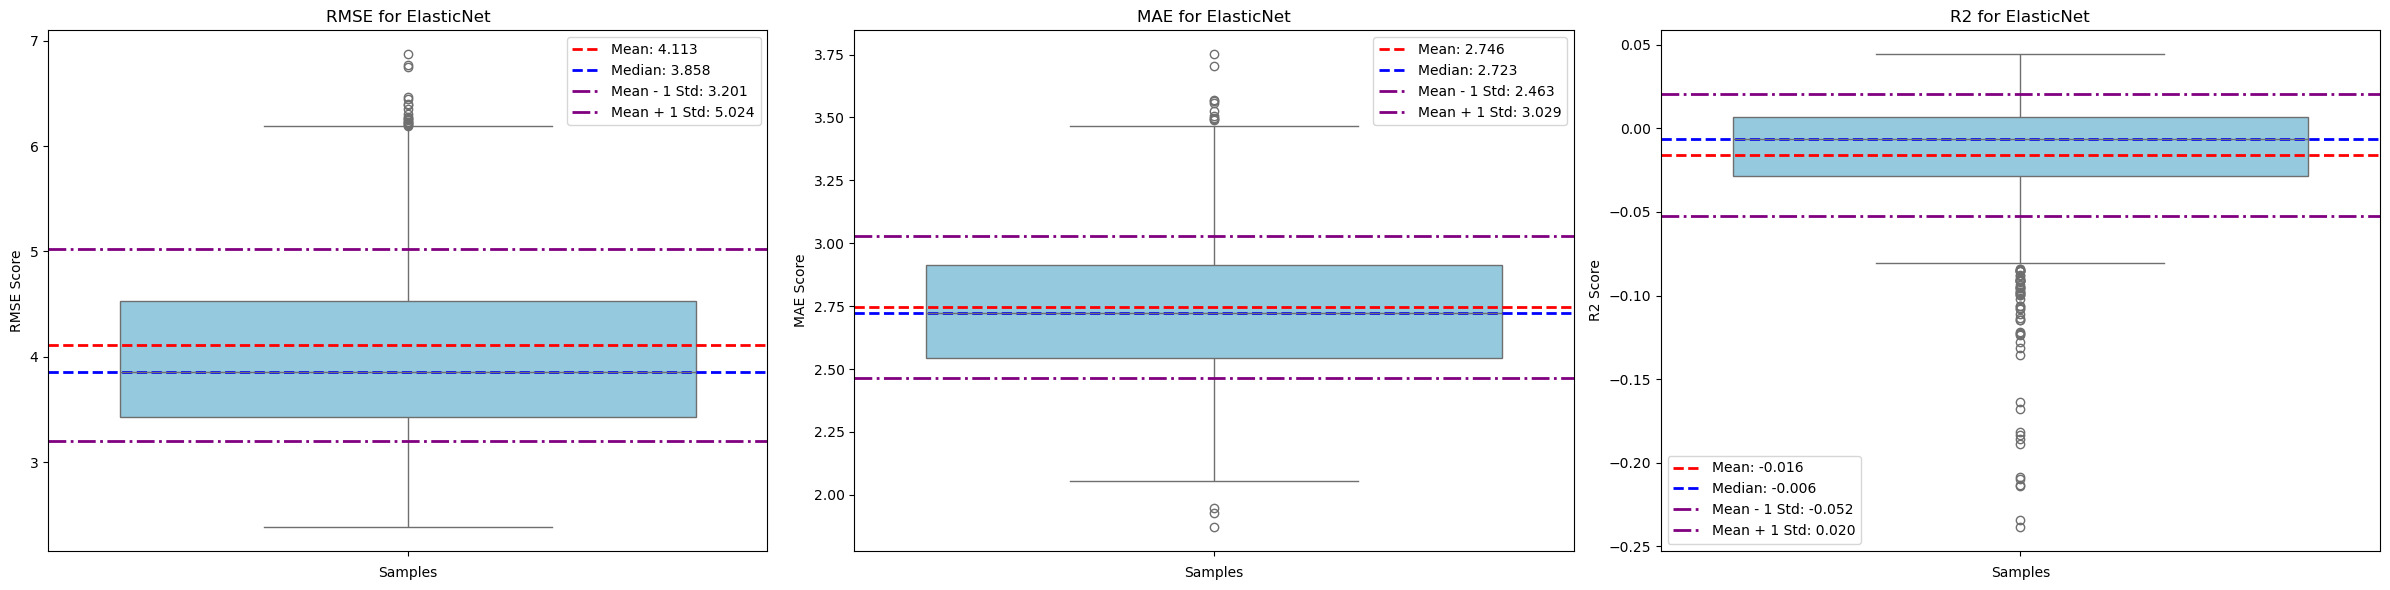

Model: BayesianRidge


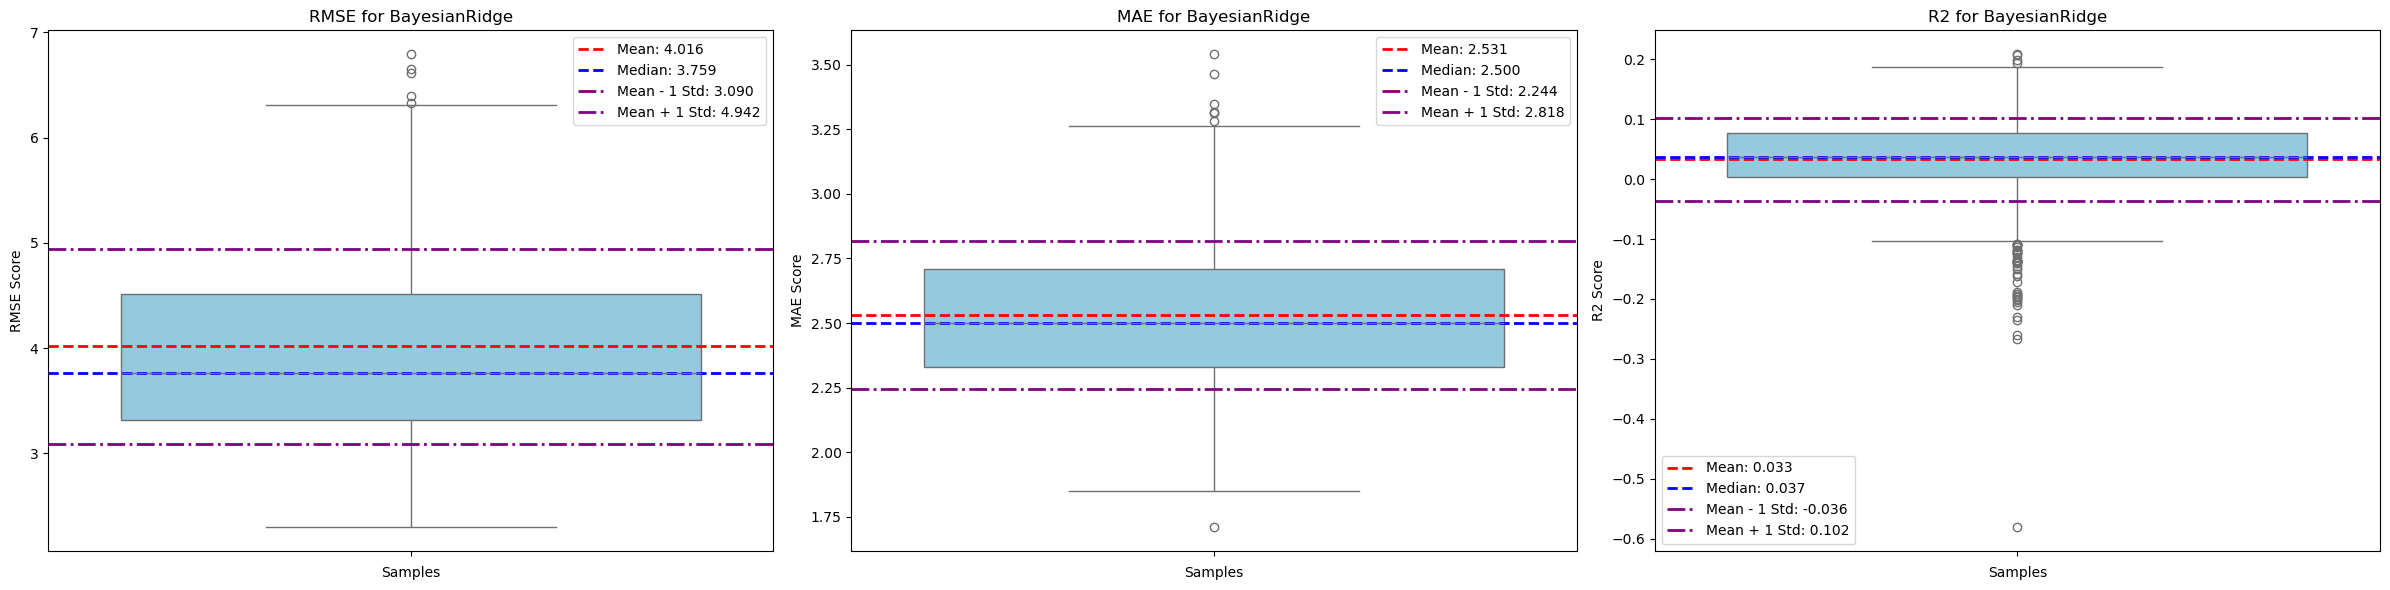

Model: SVR


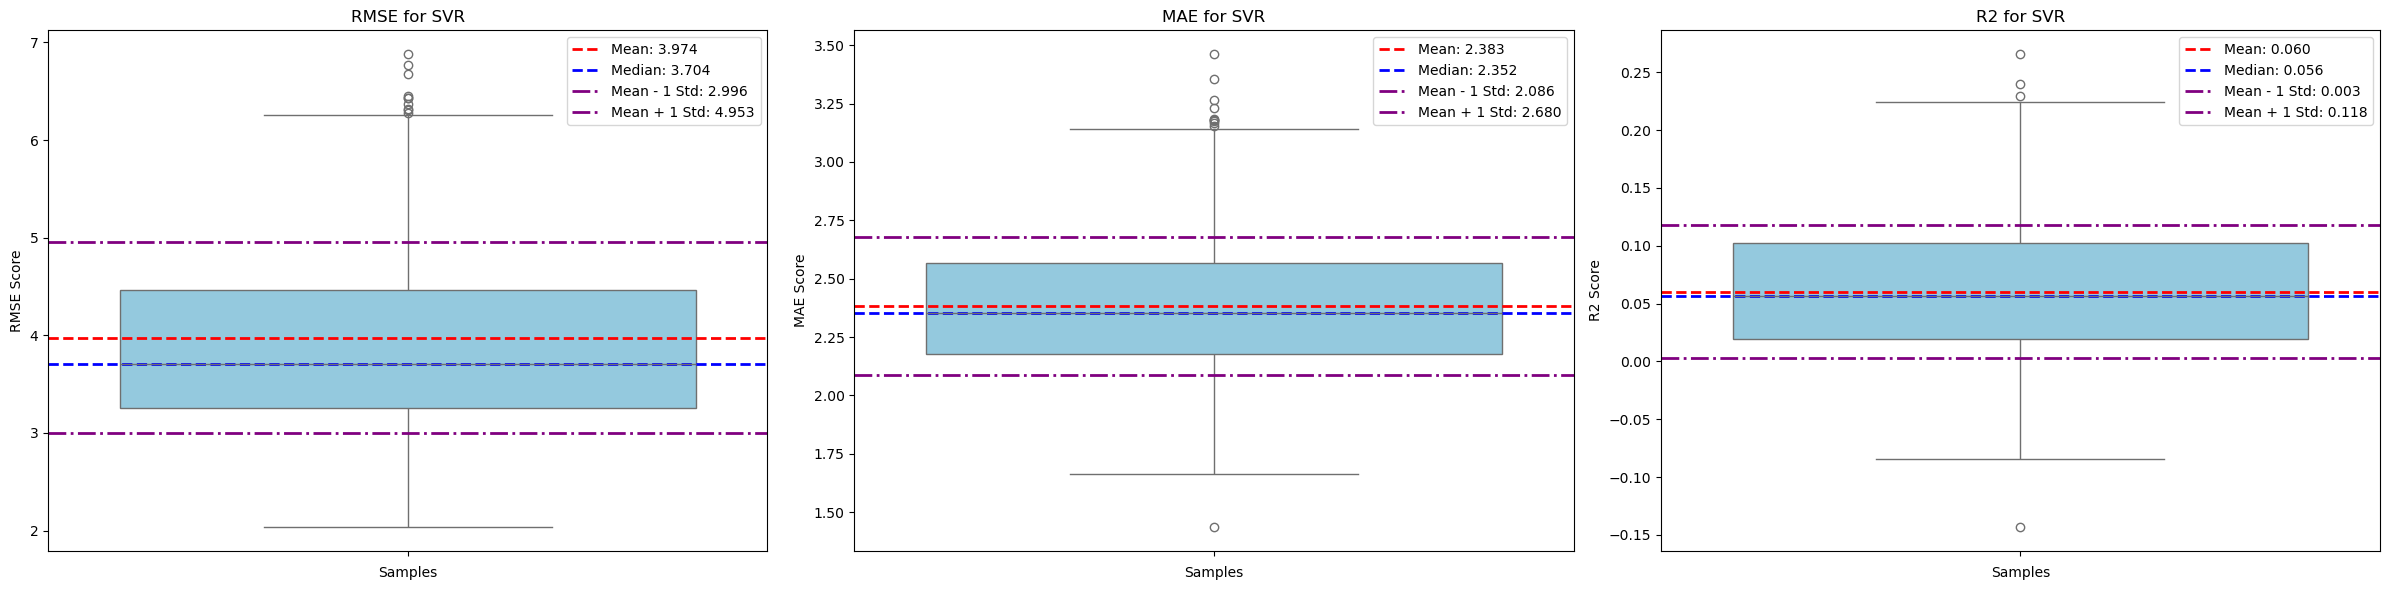

In [3]:
for model in [ElasticNet(), BayesianRidge(), SVR()]:
    print(f"Model: {model.__class__.__name__}")
    # Create a pipeline for each baseline model
    pipeline = functions.create_pipeline(model)
    # Train the model on the development set and save it
    preds, trained_pipeline = functions.train_model_and_predict(x, y, val_x, pipeline, root_path=root, filename=f"{model.__class__.__name__}.pkl", save=True)
    # Calculate metrics
    scores = functions.bootstrap(x, y, val_x, val_y, pipeline, n_iter=200, bstrap=False, kf=True)
    rmse_scores, mae_scores, r2_scores = scores['rmse_scores'], scores['mae_scores'], scores['r2_scores']
    mean_rmse, std_rmse, median_rmse = functions.calculate_statistics(rmse_scores)
    mean_mae, std_mae, median_mae = functions.calculate_statistics(mae_scores)
    mean_r2, std_r2, median_r2 = functions.calculate_statistics(r2_scores)
    # Create a boxplot
    functions.create_boxplot([rmse_scores, mae_scores, r2_scores], model.__class__.__name__, ["RMSE", "MAE", "R2"], [mean_rmse, mean_mae, mean_r2], [std_rmse, std_mae, std_r2], [median_rmse, median_mae, median_r2])

<hr>

<p>Based on the results from k-fold cross-validation, we can see that the model that seems most promising is the SVR, since it has the lowest mean absolute error (MAE), the lowest root mean squared error (RMSE) and the highest R2 score. Regarding R2, the overall distributions also show the same picture as most of the values for the SVR are found in a range higher than the other models, while it is interesting that the R2 for the ElasticNet is mostly negative, which shows that it is likely to be the least reliable, as a negative R2 score indicates predictions worse than predicting the constantly the mean. This is likely happening due to overfitting, as the other models  have positive values, although small. It is also worth noting that even though the mean and median values are higher for SVR, the std is higher than the other models.</p>

<hr>

## Evaluation - Baseline Models

<p>In order to get multiple metrics for evaluation from a single evaluation set, we use bootstrapping on the evaluation set after training once on the development set. This way, we simulate the process where the model is made to predict on multiple sets of unseen data. Ideally the metrics should be similar to the metrics we get from the kfold cross validation on the development set. It is worth mentioning that the number of samples used per iteration are half of the evaluation dataset size with `replacement=True` which means that the same sample can be picked more than once. </p>

Model: ElasticNet


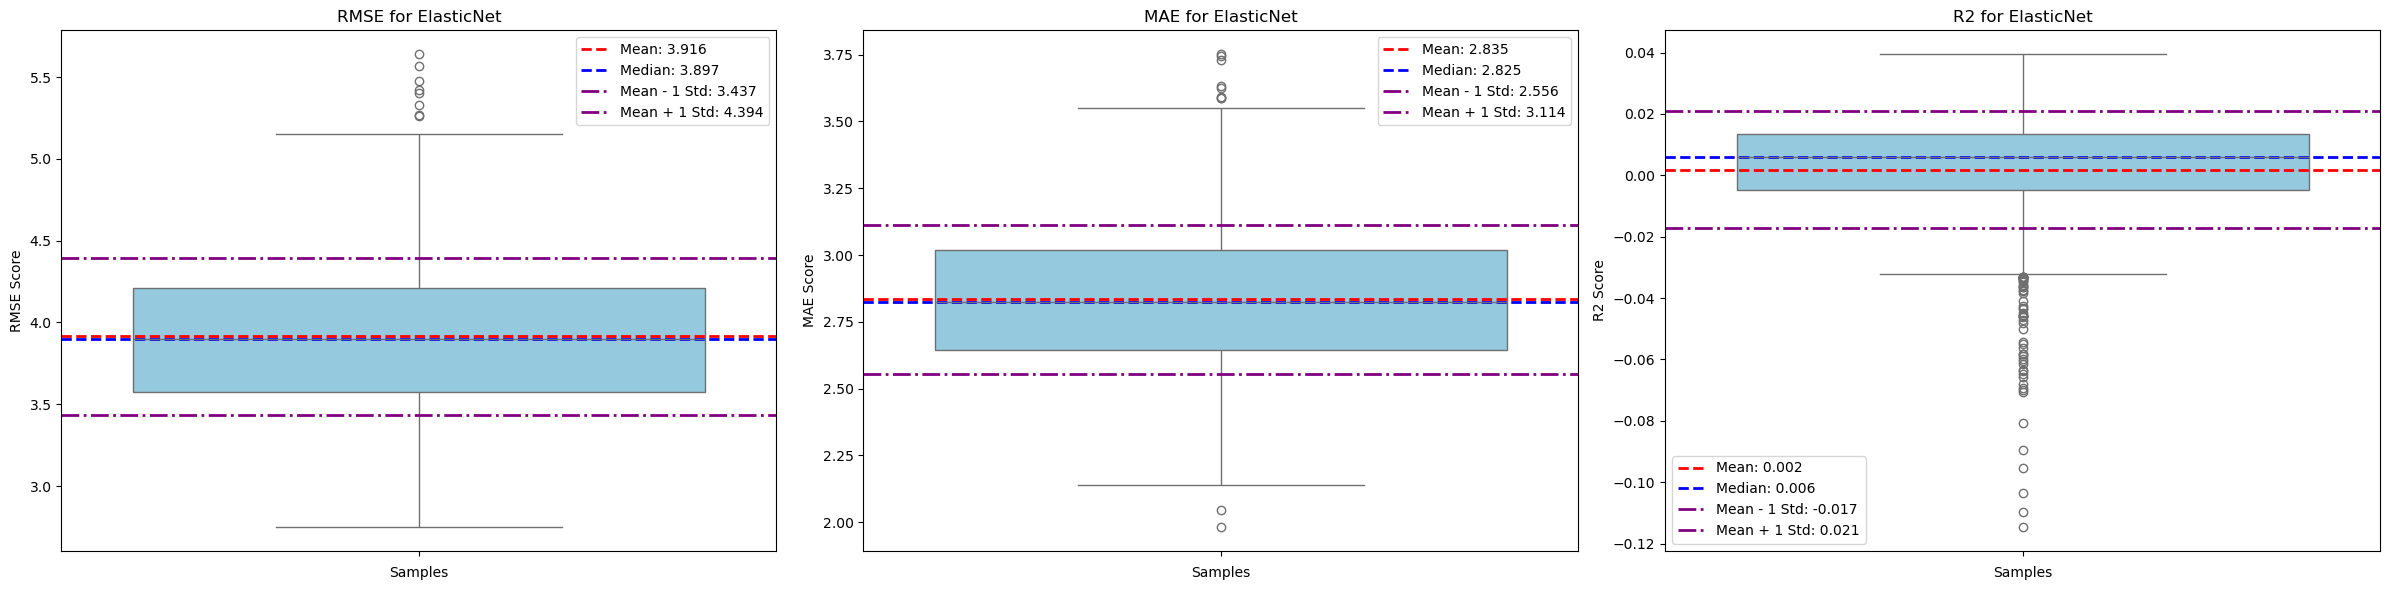

Model: BayesianRidge


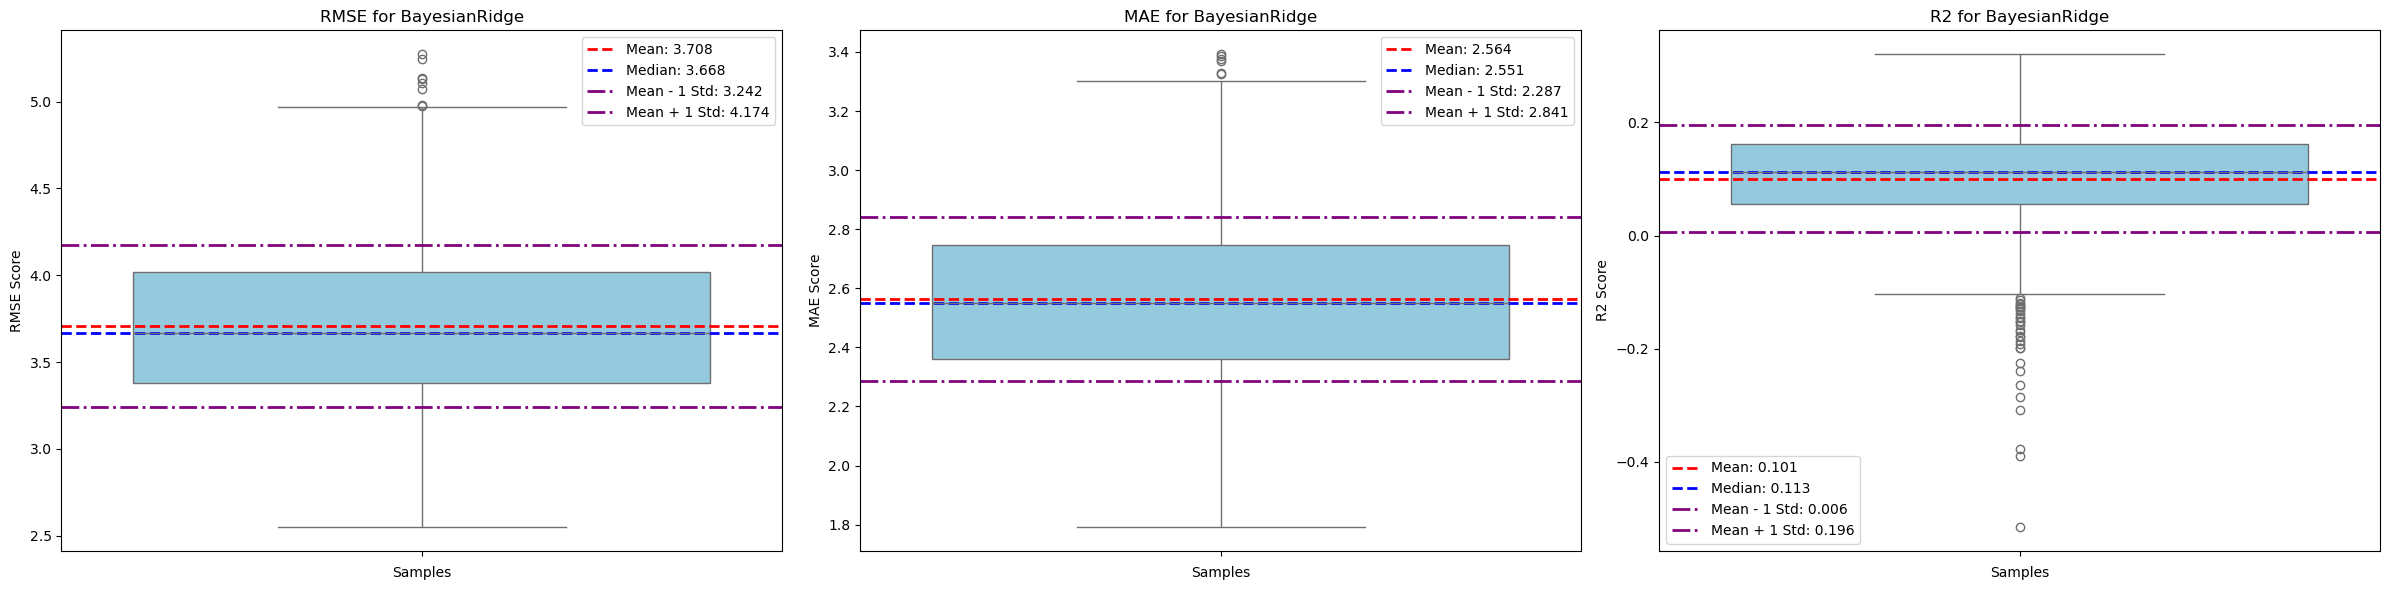

Model: SVR


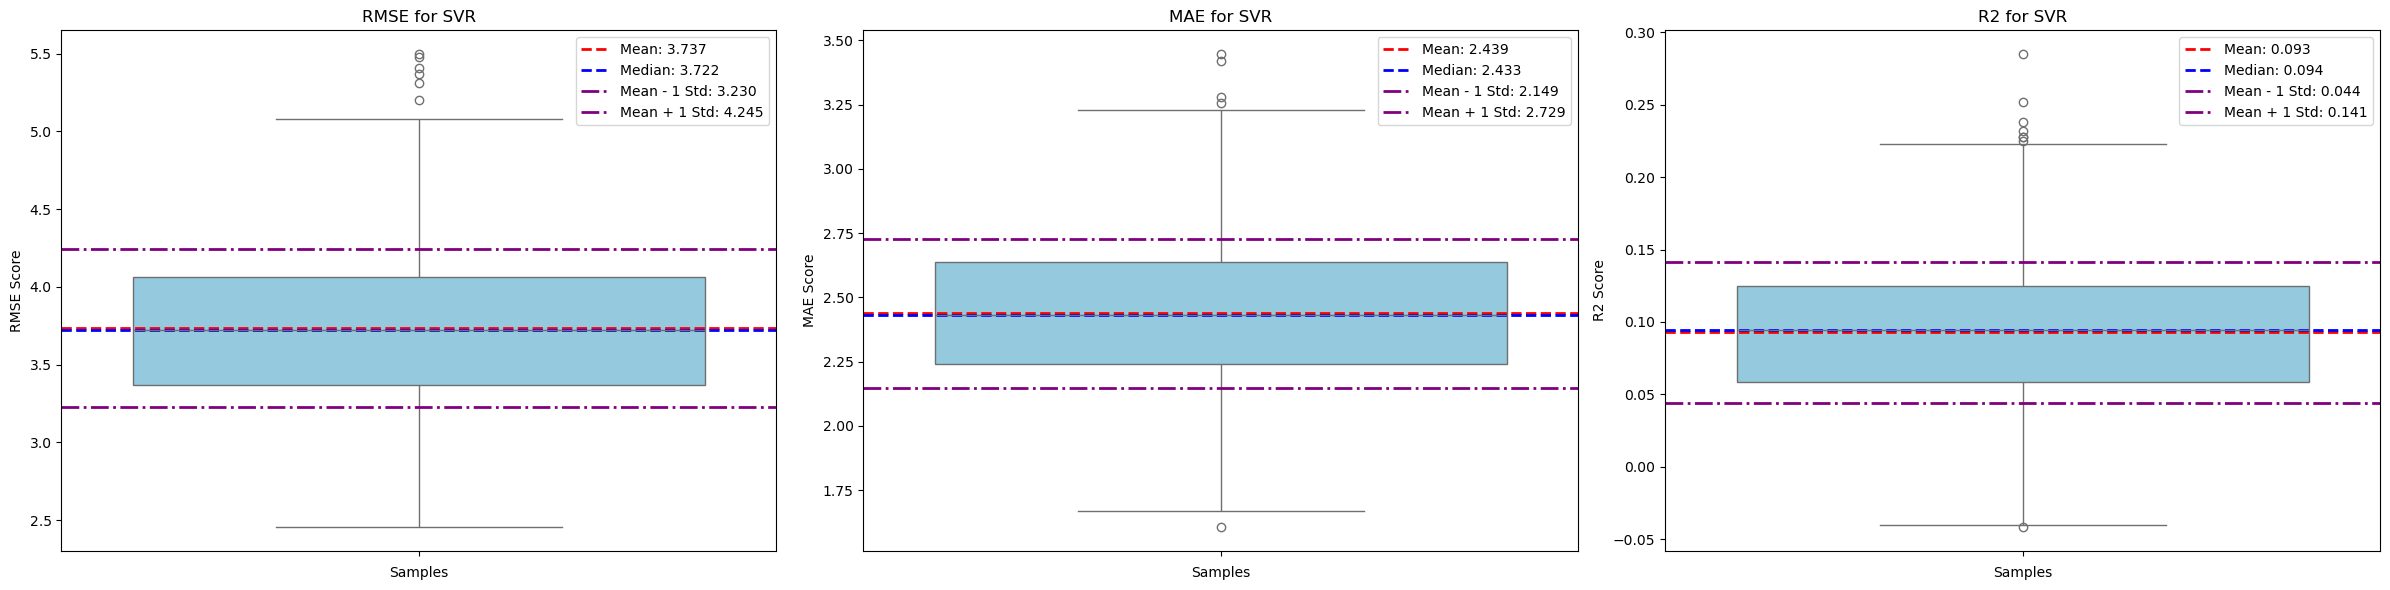

In [7]:
for model in [ElasticNet(), BayesianRidge(), SVR()]:
    print(f"Model: {model.__class__.__name__}")
    # Create a pipeline for each baseline model
    pipeline = functions.create_pipeline(model)
    preds, trained_pipeline = functions.train_model_and_predict(x, y, val_x, pipeline)
    # Calculate metrics
    scores = functions.bootstrap(x, y, val_x, val_y, pipeline, n_iter=1000, bstrap=True, kf=False)
    rmse_scores, mae_scores, r2_scores = scores['rmse_scores'], scores['mae_scores'], scores['r2_scores']
    mean_rmse, std_rmse, median_rmse = functions.calculate_statistics(rmse_scores)
    mean_mae, std_mae, median_mae = functions.calculate_statistics(mae_scores)
    mean_r2, std_r2, median_r2= functions.calculate_statistics(r2_scores)
    # Create a boxplot
    functions.create_boxplot([rmse_scores, mae_scores, r2_scores], model.__class__.__name__, ["RMSE", "MAE", "R2"], [mean_rmse, mean_mae, mean_r2], [std_rmse, std_mae, std_r2], [median_rmse, median_mae, median_r2])


<p>The plots obtained and their quality seems to be similar to the kfold results. More specifically, the scores seem to be better than the ones from kfold, which is likely due to the fact that here the training set remains the same and only the evaluation set is changing (due to bootstrapping). Finally, the R2 score here is mostly positive for all models although it is still of miniscule value. In conclusion, the evaluation shows that the most promising model is the SVR followed by the bayesian ridge, with the Elastic Net being the worse performing one of the three.</p>
<hr>

## Feature Selection
<p>In this section, we will use optuna for each baseline model in order to assess the best feature selection method among `PCA`, `KernelPCA`, `RFE` and `SelectKBest(mutual_information/r_regression)` based on the maximization of the negative`Root Mean Squared Error`. RFE(CV) was used separately so the results were compared with the best Optuna result. It should be noted that Grid search was also used, but lead to suboptimal results compared to optuna for almost every model.</p>

- <p>PCA is an unsupervised technique for dimensionality reduction in machine learning. By leveraging the eigenvectors and eigenvalues of the covariance matrix, PCA can reduce the dimensionality of the data while preserving the most important features. It is a linear transformation technique that can be applied to both numerical and categorical data. The number of components to retain is specified by the `n_components` parameter, which also allows to choose a float in order for PCA to return the number of components that explain at least a certain percentage of the variance in the data. Here we first checked how many features are required to explain 95% of the variance in the dataset and set that number as the maximum numver of features to be selected by PCA.</p>

- <p>Kernel PCA is a variant of PCA which can transform data non-linearly based on a predefined kernel (a radial basis function kernel is the default, which is basically a gaussian kernel). Although really powerful due to the fact that it can handle non-linearities, it can also distort the structure of the data so it is usually necessary to calculate the reconstruction error. Here, this will not be performed as kernel PCA is not used for the final model.</p>

- <p>RFE is a feature selection technique that can be used for both classification and regression problems. It works by recursively selecting the best features based on a cross-validation score. Apart from being computationally expensive, it also requires specific parameters to be provided by the estimator regarding the importance of features, which makes it impossible to use for SVR with the default RBF kernel.</p>

<hr>

In [21]:
models = [ElasticNet(), BayesianRidge(), SVR()]
for model in models:
    print(model.__class__.__name__)
    grid = functions.grid_search(model, x, y, cv=5, scoring='neg_root_mean_squared_error')
    print("Best parameters:", grid.best_params_)
    print("Best score:", grid.best_score_)

ElasticNet
Best parameters: {'feature_selector': PCA(), 'feature_selector__n_components': 50}
Best score: -4.0911533489601615
BayesianRidge
Best parameters: {'feature_selector': PCA(), 'feature_selector__n_components': 30}
Best score: -4.050556615384229
SVR
Best parameters: {'feature_selector': PCA(), 'feature_selector__n_components': 95}
Best score: -4.013586410812309


<hr>

#### RFE-CV

<p>RFE-CV was used for feature selection for Elastic Net and Bayesian Ridge. Afterwards, plots were made, with confidence intervals according to the documentation in sklearn to show the information gain as features increase for each algorithm.</p>

ElasticNet
Optimal number of features: 7
Selected features: ['Alistipes putredinis', 'Desulfonispora thiosulfatigenes', 'Ruminococcus champanellensis', 'Sporobacter termitidis', 'Clostridium clariflavum', 'Clostridium symbiosum', 'Eubacterium sulci']
Mean negative RMSE for optimal features (7): -4.1667


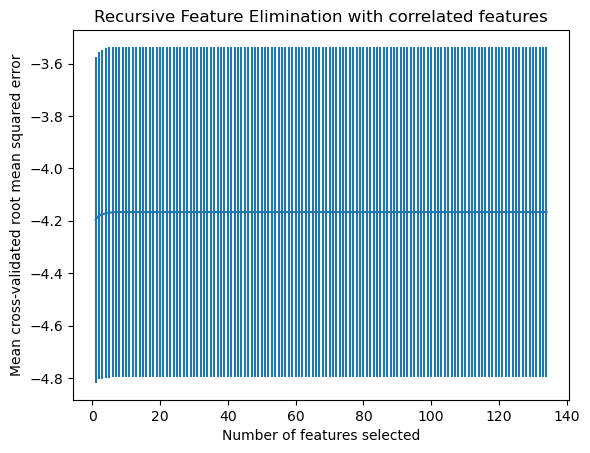

BayesianRidge
Optimal number of features: 134
Selected features: ['Acholeplasma axanthum', 'Acidaminococcus fermentans', 'Acidaminococcus intestini', 'Actinomyces lingnae', 'Akkermansia muciniphila', 'Alistipes finegoldii', 'Alistipes indistinctus', 'Alistipes obesi', 'Alistipes onderdonkii', 'Alistipes putredinis', 'Alistipes shahii', 'Alistipes sp. RMA 9912', 'Alistipes timonensis', 'Anaerofilum pentosovorans', 'Anaerofustis stercorihominis', 'Anaerostipes butyraticus', 'Anaerostipes caccae', 'Anaerotruncus colihominis', 'Bacillus megaterium', 'Bacillus nealsonii', 'Bacteroides eggerthii', 'Bacteroides fragilis', 'Bacteroides gallinarum', 'Bacteroides graminisolvens', 'Bacteroides intestinalis', 'Bacteroides massiliensis', 'Bacteroides ovatus', 'Bacteroides plebeius', 'Bacteroides salyersiae', 'Barnesiella viscericola', 'Bifidobacterium bifidum', 'Bifidobacterium pseudocatenulatum', 'Bifidobacterium saguini', 'Bifidobacterium tsurumiense', 'Bilophila wadsworthia', 'Blautia coccoides'

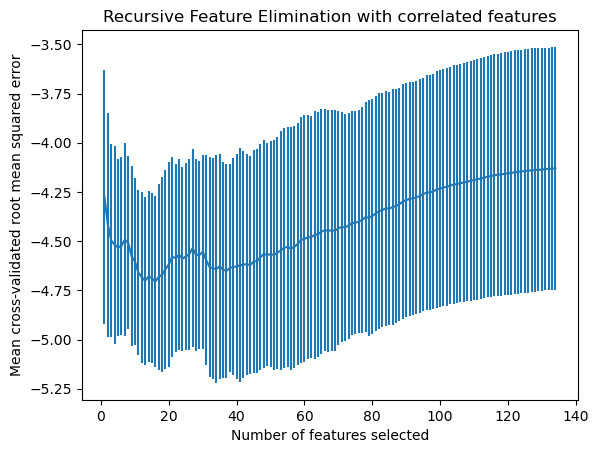

In [22]:
from sklearn.feature_selection import RFECV
models = [ElasticNet(), BayesianRidge()]
cv = KFold(n_splits=5, shuffle=True, random_state=42)
features_per_model = {}
for model in models:
    features_per_model[model.__class__.__name__] = []
    print(model.__class__.__name__)
    rfecv = RFECV(estimator=model, 
                step=1, cv=cv, 
                scoring='neg_root_mean_squared_error',
                min_features_to_select=1
                )
    rfecv.fit(x, y)
    print('Optimal number of features: %d' % rfecv.n_features_)
    # If x is a DataFrame, this will list the selected features by name.
    selected_features = x.columns[rfecv.support_]
    selected_features_list = selected_features.tolist()
    features_per_model[model.__class__.__name__].extend(selected_features_list)
    print("Selected features:", selected_features_list)
    # Number of features tested by RFE:
    n_features_list = np.arange(
        rfecv.min_features_to_select, 
        x.shape[1] + 1,               
        rfecv.step                     
    )

    # Make sure we only take as many points as in cv_results_:
    n_features_list = n_features_list[:len(rfecv.cv_results_["mean_test_score"])]
    optimal_index = list(n_features_list).index(rfecv.n_features_)
    optimal_score = rfecv.cv_results_["mean_test_score"][optimal_index]
    print("Mean negative RMSE for optimal features ({}): {:.4f}".format(rfecv.n_features_, optimal_score))

    # Now you can plot
    cv_results = pd.DataFrame(rfecv.cv_results_)
    plt.errorbar(
        x=n_features_list,
        y=cv_results["mean_test_score"],
        yerr=cv_results["std_test_score"],
    )
    plt.xlabel("Number of features selected")
    plt.ylabel("Mean cross-validated root mean squared error")
    plt.title("Recursive Feature Elimination with correlated features")
    plt.show()


In [23]:
# Train each model with its corresponding features
x_mod_elnet = x[features_per_model['ElasticNet']]
x_mod_bayesian = x[features_per_model['BayesianRidge']]
x_val_elnet = val_x[features_per_model['ElasticNet']]
x_val_bayesian = val_x[features_per_model['BayesianRidge']]
print(x_mod_elnet.shape)
print(x_mod_bayesian.shape)

(489, 7)
(489, 134)


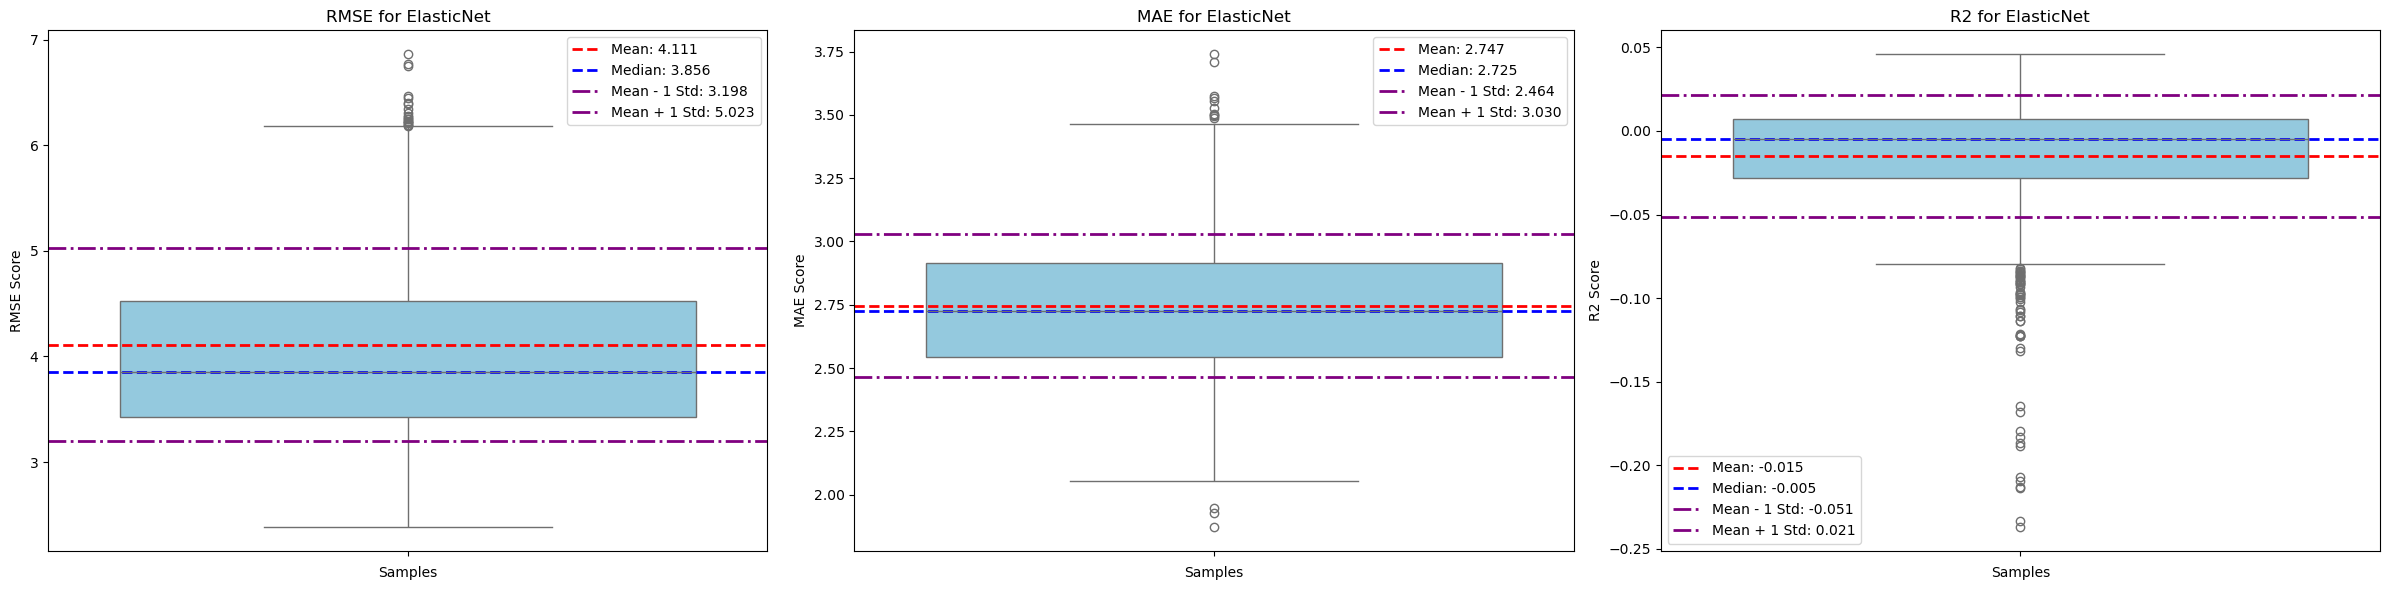

In [24]:
model = ElasticNet()
# Create a pipeline for each baseline model
pipeline = functions.create_pipeline(model)
preds, trained_pipeline = functions.train_model_and_predict(x_mod_elnet, y, x_val_elnet, pipeline, root_path=root, filename=f"{model.__class__.__name__}_rfe.pkl", save=True)
# Calculate metrics
scores = functions.bootstrap(x_mod_elnet, y, x_val_elnet, val_y, pipeline, n_iter=200, bstrap=False, kf=True)
rmse_scores, mae_scores, r2_scores = scores['rmse_scores'], scores['mae_scores'], scores['r2_scores']
mean_rmse, std_rmse, median_rmse = functions.calculate_statistics(rmse_scores)
mean_mae, std_mae, median_mae = functions.calculate_statistics(mae_scores)
mean_r2, std_r2, median_r2 = functions.calculate_statistics(r2_scores)
# Create a boxplot
functions.create_boxplot([rmse_scores, mae_scores, r2_scores], model.__class__.__name__, ["RMSE", "MAE", "R2"], [mean_rmse, mean_mae, mean_r2], [std_rmse, std_mae, std_r2], [median_rmse, median_mae, median_r2])


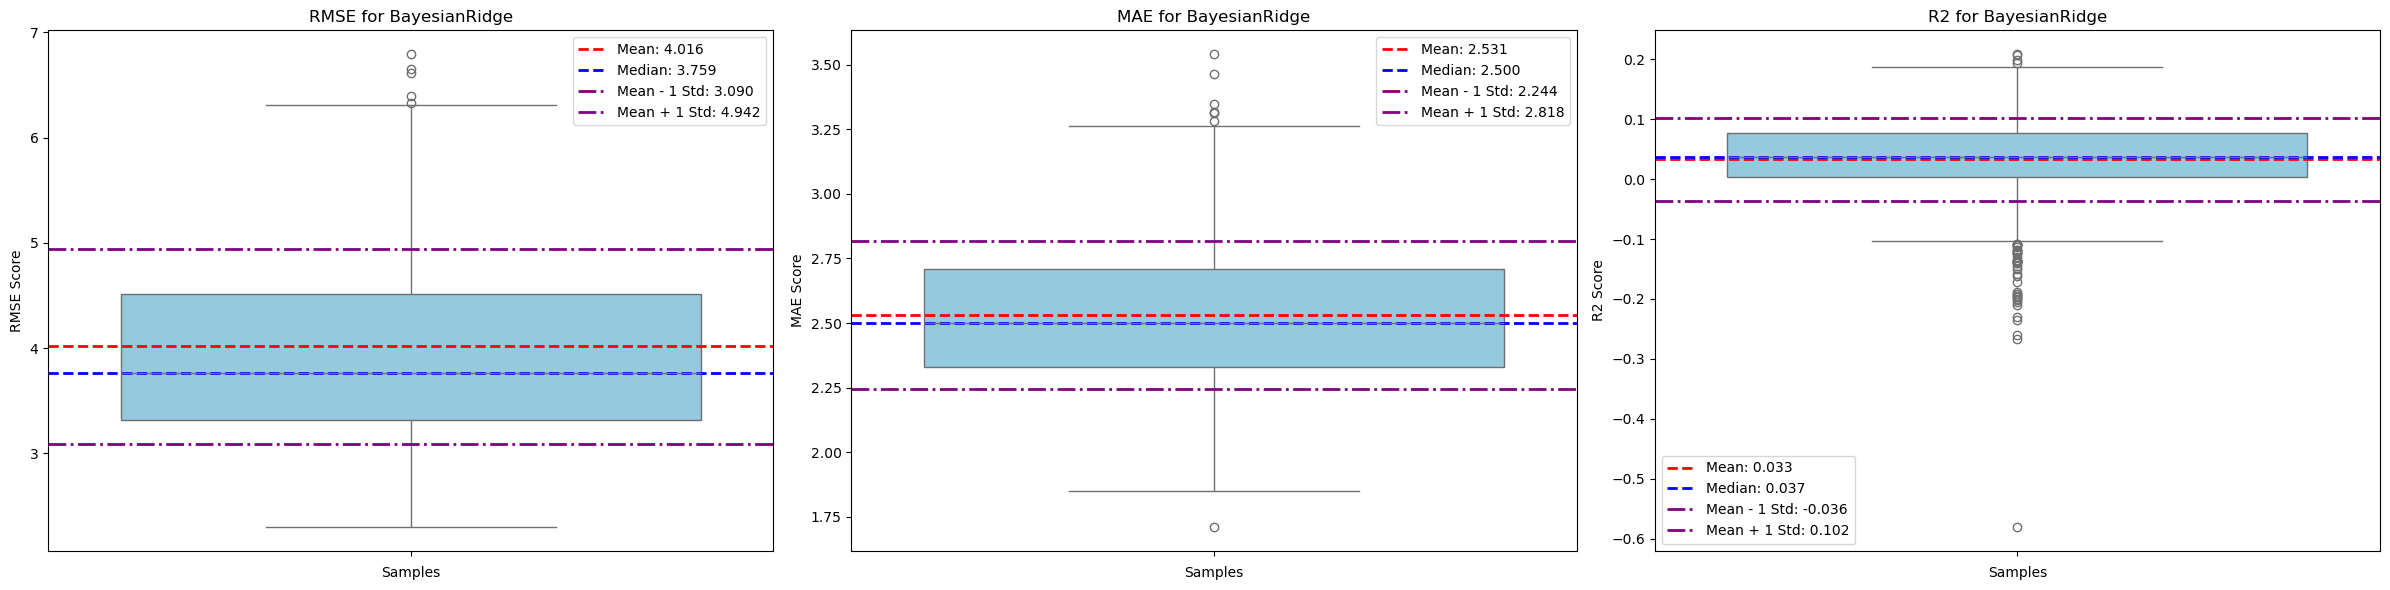

In [25]:
model = BayesianRidge()
# Create a pipeline for each baseline model
pipeline = functions.create_pipeline(model)
preds, trained_pipeline = functions.train_model_and_predict(x_mod_bayesian, y, x_val_bayesian, pipeline, root_path=root, filename=f"{model.__class__.__name__}_rfe.pkl", save=True)
# Calculate metrics
scores = functions.bootstrap(x_mod_bayesian, y, x_val_bayesian, val_y, pipeline, n_iter=200, bstrap=False, kf=True)
rmse_scores, mae_scores, r2_scores = scores['rmse_scores'], scores['mae_scores'], scores['r2_scores']
mean_rmse, std_rmse, median_rmse = functions.calculate_statistics(rmse_scores)
mean_mae, std_mae, median_mae = functions.calculate_statistics(mae_scores)
mean_r2, std_r2, median_r2 = functions.calculate_statistics(r2_scores)
# Create a boxplot
functions.create_boxplot([rmse_scores, mae_scores, r2_scores], model.__class__.__name__, ["RMSE", "MAE", "R2"], [mean_rmse, mean_mae, mean_r2], [std_rmse, std_mae, std_r2], [median_rmse, median_mae, median_r2])


<p>Although, the number of features for Elastic Net are dramatically reduced, the RMSE seems to be higher than with the PCA suggested by Grid-search. Additionally, the number of features for Bayesian Ridge are not significantly reduced while at the same time, the confidence intervals (for Elastic Net) are quite wide, showing that there is a lot of uncertainty in the results.</p>

<p>The boxplots created after choosing only the features obtained from RFE-CV show that the results are similar with the baseline models before feature selection, however we also need to figure out a good feature selection method for SVR. Thus, the results of Optuna will also be examined to select the best feature selection method for each model.</p>

<hr>
</p>Optuna was used to select the best feature selection technique for each model. The results were then plotted using boxplots to visualize the performance of the suggested techniques based on the three scores mentioned</p>

In [3]:
models = [ElasticNet(), BayesianRidge(), SVR()]
for model in models:
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: functions.optuna_dim_reduction(trial, model, x, y), n_trials=100)
    print(study.best_params)

[I 2025-03-20 09:39:06,020] A new study created in memory with name: no-name-e3535483-0454-45d4-9522-9aaa55dc3067
[I 2025-03-20 09:39:06,740] Trial 0 finished with value: -4.1642797095015975 and parameters: {'method': 'SelectKBest', 'sk_method': 'mutual_info_regression', 'k': 23}. Best is trial 0 with value: -4.1642797095015975.
[I 2025-03-20 09:39:06,837] Trial 1 finished with value: -4.113873035708648 and parameters: {'method': 'PCA', 'n_components': 30}. Best is trial 1 with value: -4.113873035708648.
[I 2025-03-20 09:39:06,916] Trial 2 finished with value: -4.113284848049341 and parameters: {'method': 'PCA', 'n_components': 66}. Best is trial 2 with value: -4.113284848049341.
[I 2025-03-20 09:39:07,000] Trial 3 finished with value: -4.107258557071807 and parameters: {'method': 'PCA', 'n_components': 90}. Best is trial 3 with value: -4.107258557071807.
[I 2025-03-20 09:39:07,040] Trial 4 finished with value: -4.198524061463716 and parameters: {'method': 'SelectKBest', 'sk_method': '

{'method': 'PCA', 'n_components': 90}


[I 2025-03-20 09:39:21,815] Trial 2 finished with value: -4.106259837448325 and parameters: {'method': 'SelectKBest', 'sk_method': 'mutual_info_regression', 'k': 69}. Best is trial 2 with value: -4.106259837448325.
[I 2025-03-20 09:39:22,020] Trial 3 finished with value: -4.167342239623112 and parameters: {'method': 'KernelPCA', 'kernel': 'poly', 'degree': 4, 'n_components': 75}. Best is trial 2 with value: -4.106259837448325.
[I 2025-03-20 09:39:22,112] Trial 4 finished with value: -4.090318233804723 and parameters: {'method': 'PCA', 'n_components': 52}. Best is trial 4 with value: -4.090318233804723.
[I 2025-03-20 09:39:22,360] Trial 5 finished with value: -4.1676722661909 and parameters: {'method': 'KernelPCA', 'kernel': 'poly', 'degree': 5, 'n_components': 92}. Best is trial 4 with value: -4.090318233804723.
[I 2025-03-20 09:39:22,548] Trial 6 finished with value: -4.163000761922407 and parameters: {'method': 'KernelPCA', 'kernel': 'poly', 'degree': 3, 'n_components': 61}. Best is 

{'method': 'SelectKBest', 'sk_method': 'mutual_info_regression', 'k': 81}


[I 2025-03-20 09:40:09,047] Trial 0 finished with value: -4.073896751789379 and parameters: {'method': 'SelectKBest', 'sk_method': 'mutual_info_regression', 'k': 52}. Best is trial 0 with value: -4.073896751789379.
[I 2025-03-20 09:40:09,145] Trial 1 finished with value: -4.099191334046757 and parameters: {'method': 'PCA', 'n_components': 6}. Best is trial 0 with value: -4.073896751789379.
[I 2025-03-20 09:40:09,315] Trial 2 finished with value: -4.080891936932192 and parameters: {'method': 'KernelPCA', 'kernel': 'linear', 'n_components': 18}. Best is trial 0 with value: -4.073896751789379.
[I 2025-03-20 09:40:09,596] Trial 3 finished with value: -4.049166485365 and parameters: {'method': 'KernelPCA', 'kernel': 'rbf', 'n_components': 67}. Best is trial 3 with value: -4.049166485365.
[I 2025-03-20 09:40:10,397] Trial 4 finished with value: -4.031951985898809 and parameters: {'method': 'SelectKBest', 'sk_method': 'mutual_info_regression', 'k': 88}. Best is trial 4 with value: -4.03195198

{'method': 'PCA', 'n_components': 82}


According to Optuna: 
- The best feature selection method for ElasticNet is PCA with 90 components. 

- The best feature selection method for BayesianRidge is SelectKBest using mutual information as the scoring function with k=81. 

- The best feature selection method for SVR is PCA with 82 components.

Model: ElasticNet


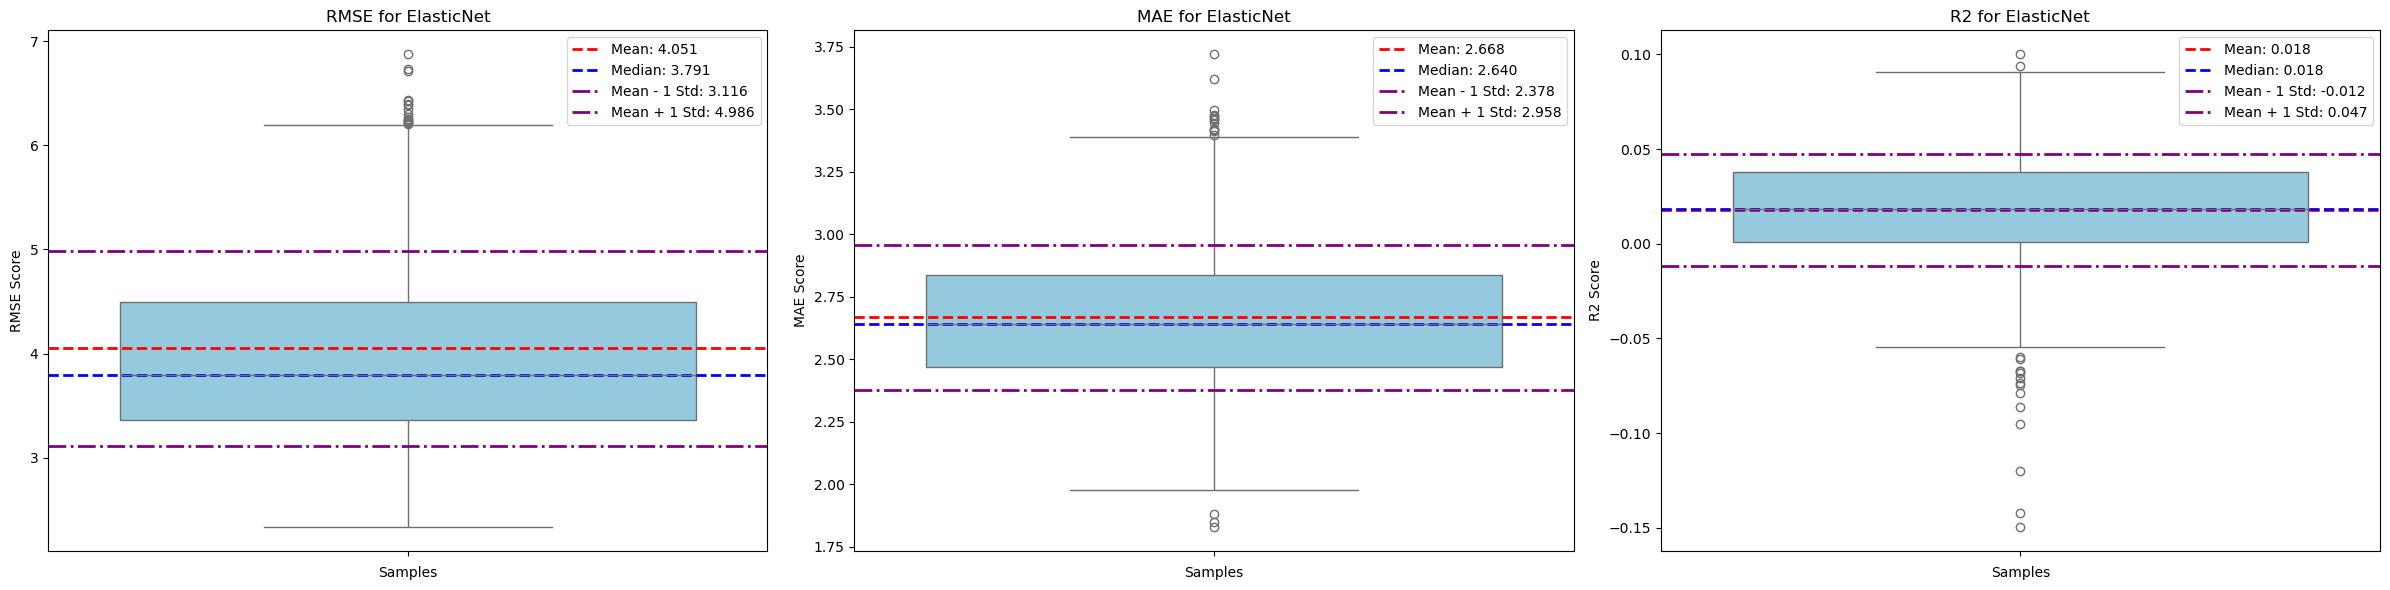

Model: BayesianRidge


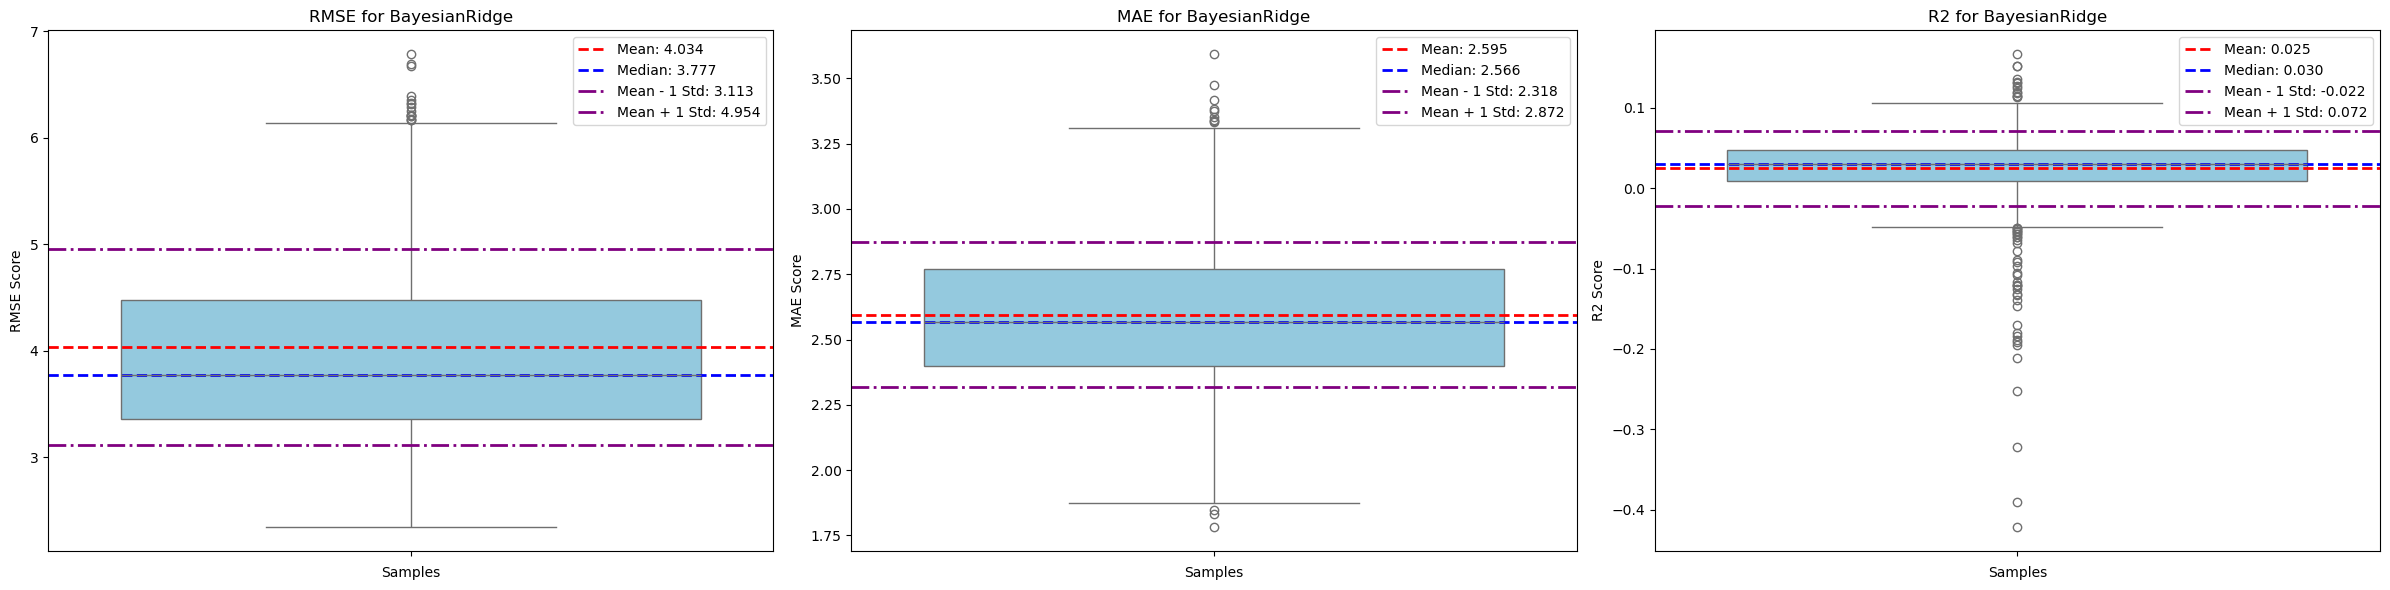

Model: SVR


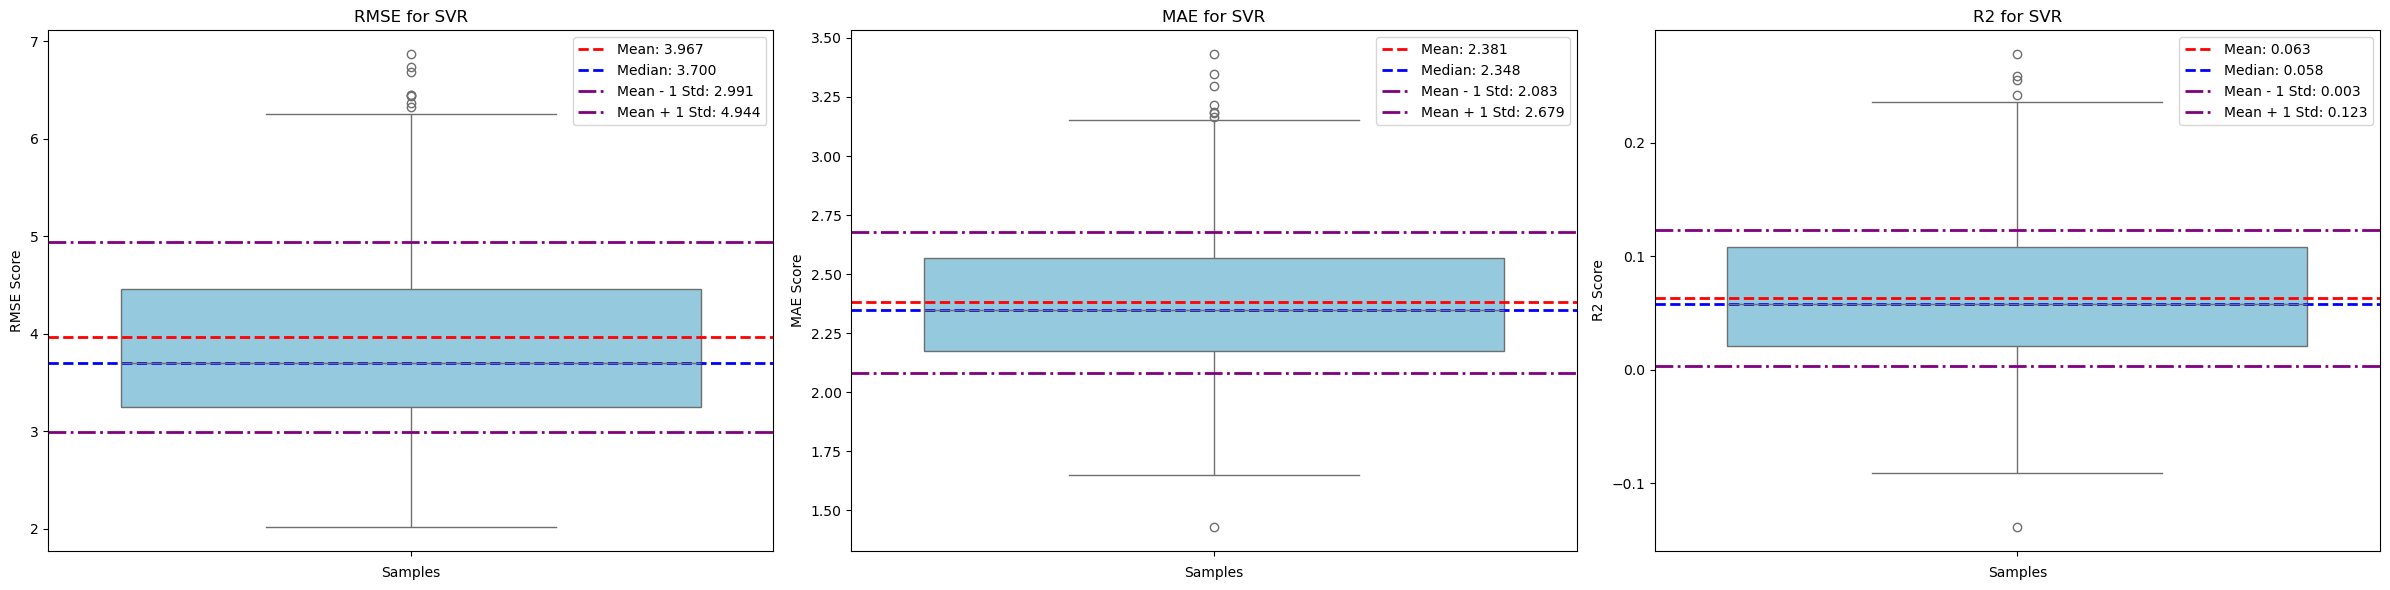

In [3]:
models = [ElasticNet(), BayesianRidge(), SVR()]
for model in models:
    print(f"Model: {model.__class__.__name__}")
    if model.__class__.__name__ == 'ElasticNet':
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=PCA(n_components=90))
        preds, trained_pipeline = functions.train_model_and_predict(x, y, val_x, pipeline, root_path=root, filename=f"{model.__class__.__name__}_pca.pkl", save=True)

    elif model.__class__.__name__ == 'BayesianRidge':
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=SelectKBest(score_func=mutual_info_regression, k=81))
        preds, trained_pipeline = functions.train_model_and_predict(x, y, val_x, pipeline, root_path=root, filename=f"{model.__class__.__name__}_selectkbest.pkl", save=True)

    else:
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=PCA(n_components=82))
        preds, trained_pipeline = functions.train_model_and_predict(x, y, val_x, pipeline, root_path=root, filename=f"{model.__class__.__name__}_pca.pkl", save=True)
    scores = functions.bootstrap(x, y, val_x, val_y, pipeline, n_iter=200, bstrap=False, kf=True)
    rmse_scores, mae_scores, r2_scores = scores['rmse_scores'], scores['mae_scores'], scores['r2_scores']
    mean_rmse, std_rmse, median_rmse = functions.calculate_statistics(rmse_scores)
    mean_mae, std_mae, median_mae = functions.calculate_statistics(mae_scores)
    mean_r2, std_r2, median_r2 = functions.calculate_statistics(r2_scores)
    # Create a boxplot
    functions.create_boxplot([rmse_scores, mae_scores, r2_scores], model.__class__.__name__, ["RMSE", "MAE", "R2"], [mean_rmse, mean_mae, mean_r2], [std_rmse, std_mae, std_r2], [median_rmse, median_mae, median_r2])



<p>All three options achieve a significant reduction in the number of features and a reduction in the RMSE score compared to RFE-CV. Notably, regarding BayesianRidge, the RFECV seems to be performing slightly better than the optuna suggested method of SelectKBest, however due to the tradeoff in the number of features is worth using the Optuna suggested methods instead. Additionally, R2 score seems to have improved after feature selection for all models, while the same holds true for the evaluation plots.</p>

Model: ElasticNet


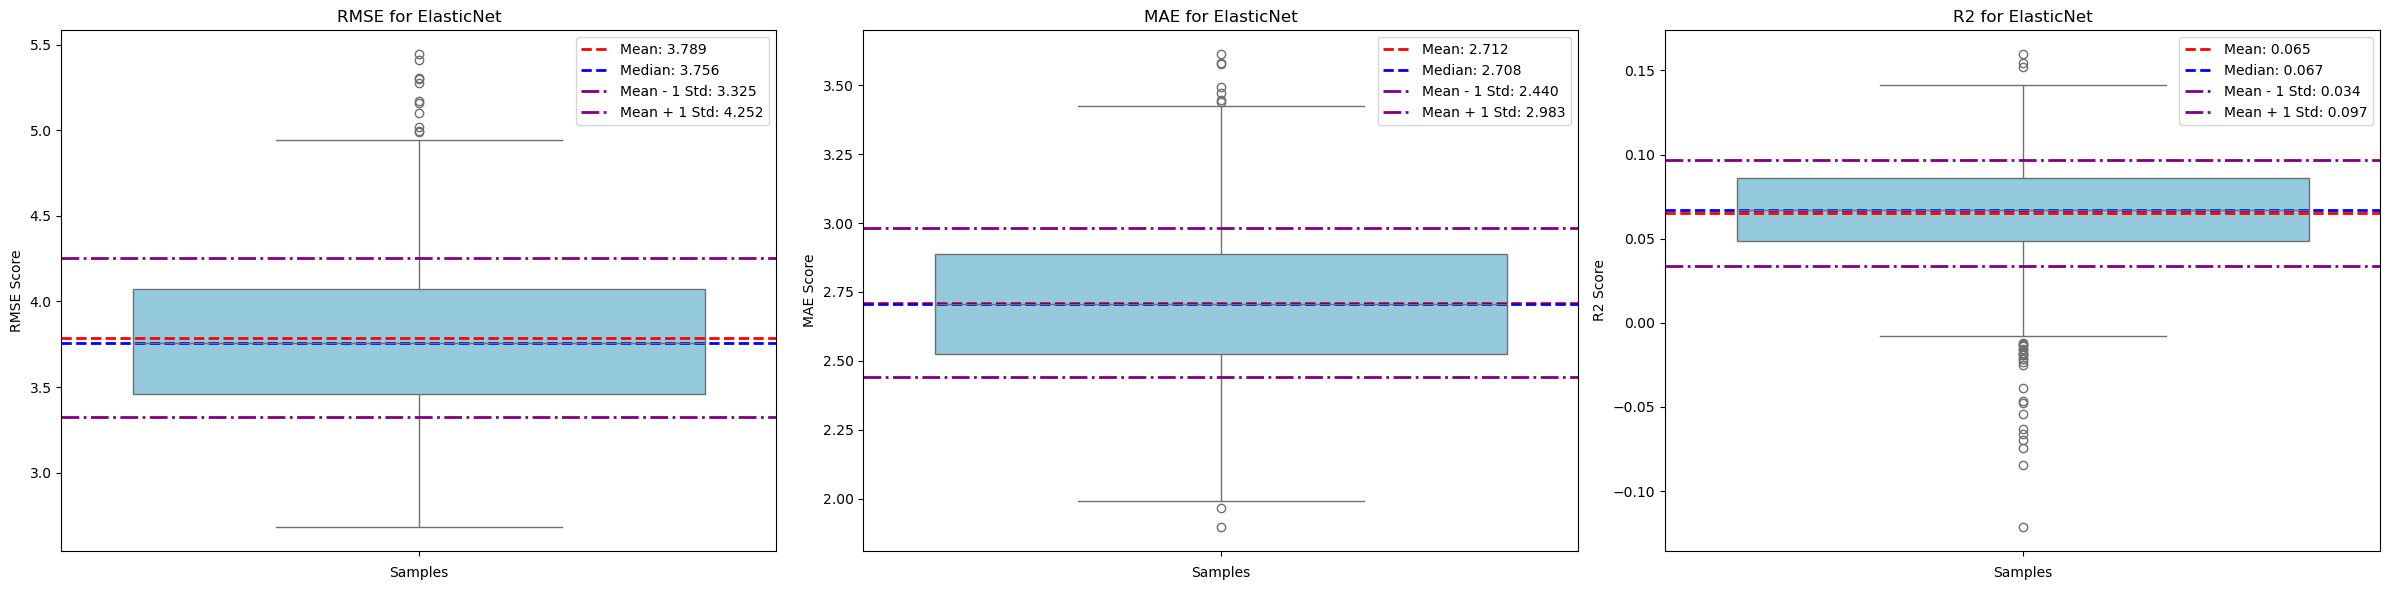

Model: BayesianRidge


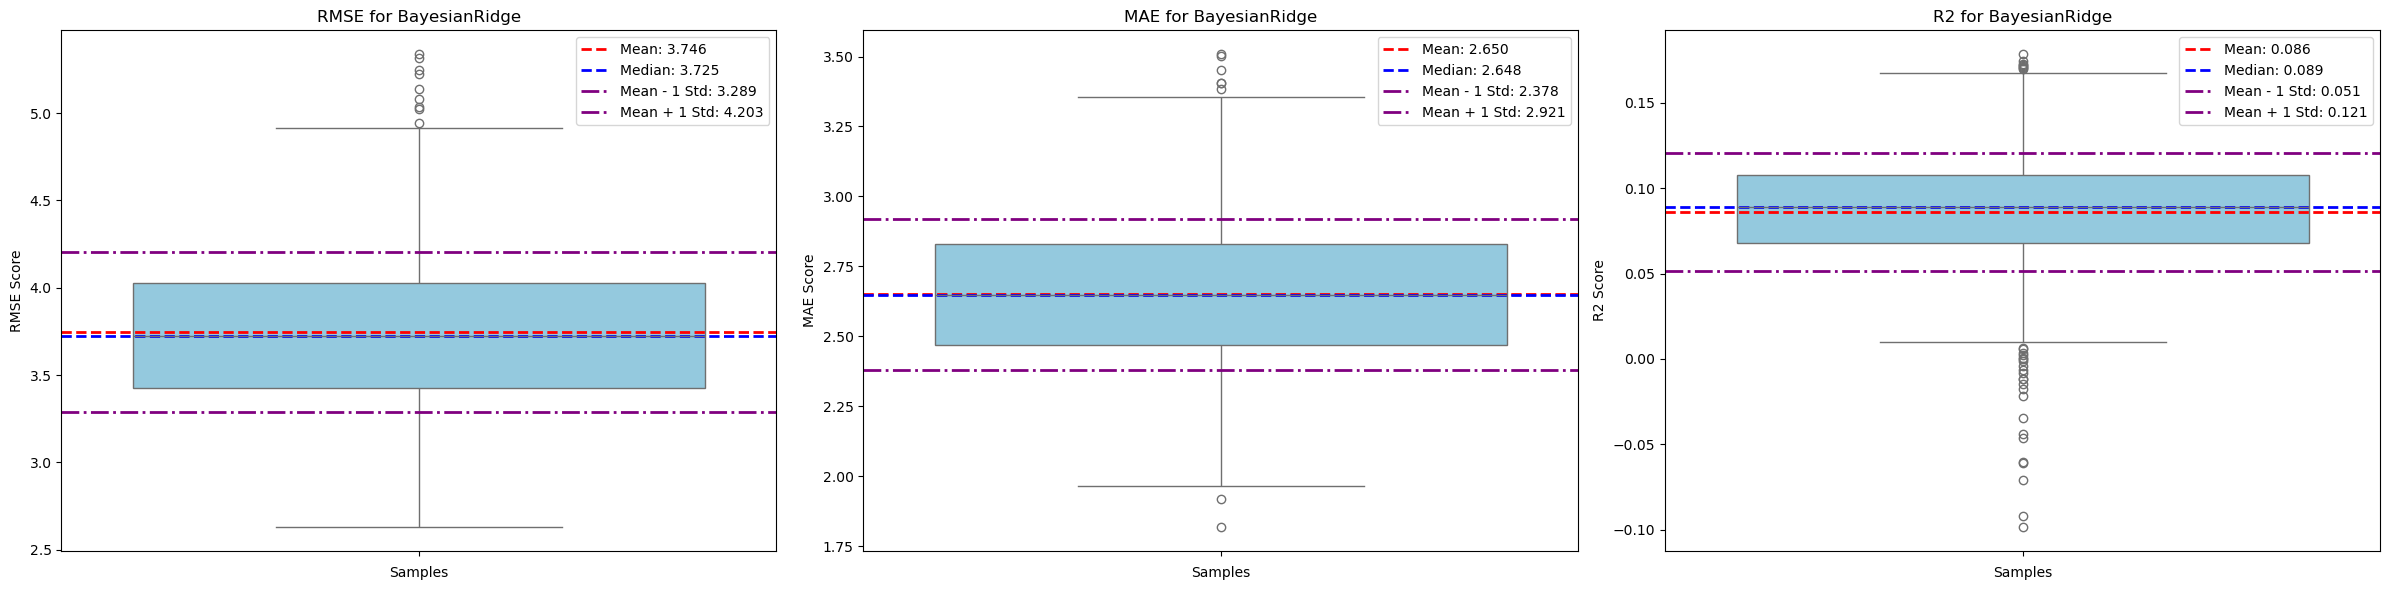

Model: SVR


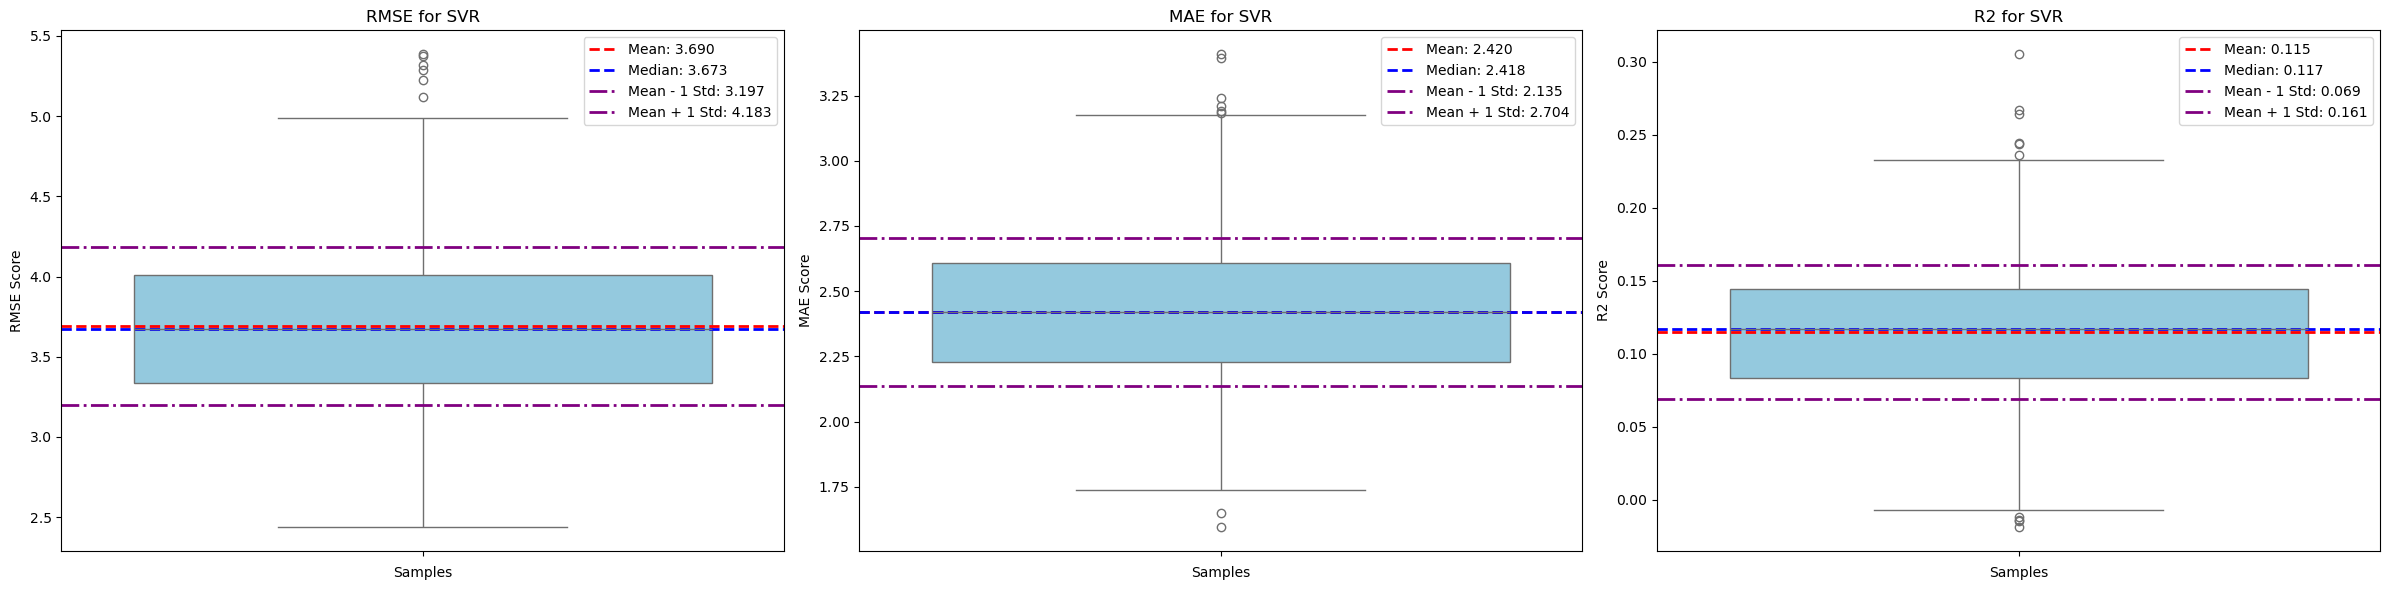

In [4]:
models = [ElasticNet(), BayesianRidge(), SVR()]
for model in models:
    print(f"Model: {model.__class__.__name__}")
    if model.__class__.__name__ == 'ElasticNet':
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=PCA(n_components=90))

    elif model.__class__.__name__ == 'BayesianRidge':
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=SelectKBest(score_func=mutual_info_regression, k=81))

    else:
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=PCA(n_components=82))
    scores = functions.bootstrap(x, y, val_x, val_y, pipeline, n_iter=1000, bstrap=True, kf=False)
    rmse_scores, mae_scores, r2_scores = scores['rmse_scores'], scores['mae_scores'], scores['r2_scores']
    mean_rmse, std_rmse, median_rmse = functions.calculate_statistics(rmse_scores)
    mean_mae, std_mae, median_mae = functions.calculate_statistics(mae_scores)
    mean_r2, std_r2, median_r2 = functions.calculate_statistics(r2_scores)
    # Create a boxplot
    functions.create_boxplot([rmse_scores, mae_scores, r2_scores], model.__class__.__name__, ["RMSE", "MAE", "R2"], [mean_rmse, mean_mae, mean_r2], [std_rmse, std_mae, std_r2], [median_rmse, median_mae, median_r2])



<hr>

## Fine-tuning

<p>After performing feature selection, we used Optuna to perform fine-tuning on the hyperparameters of the three algorithms with the objective of maximizing the negative root mean squared error (RMSE). For each algorithm, we used the following search space:</p>

1. **ElasticNet**:
    - alpha: [0.1, 10]
    - l1_ratio: [0.1, 10]

2. **BayesianRidge**:
    - alpha_1: [1e-8, 1e-4]
    - lambda_1: [1e-8, 1e-4]
    - alpha_2: [1e-8, 1e-4]
    - lambda_2: [1e-8, 1e-4]

3. **SVR**:
    - C: [0.1, 10]
    - epsilon: [0.01, 1]
    - gamma: ['scale', 'auto']
    - kernel: ['linear', 'poly', 'rbf']
    - degree: [2, 5]
    - coef0: [0, 1]



In [3]:
models = [ElasticNet(), BayesianRidge(), SVR()]
for model in models:
# Run Optuna optimization
        study = optuna.create_study(direction="maximize")
        # I had to use chatgpt for the following line, to figure out how to pass the model and x and y to the optuna_objective function
        study.optimize(lambda trial: functions.optuna_objective(trial, model, x, y), n_trials=100)
        # Best hyperparameters
        print("Study statistics: ")
        print("  Number of finished trials: ", len(study.trials))
        print("Best trial:")
        trial = study.best_trial
        print("  Value: ", trial.value)
        print("  Params: ")
        for key, value in trial.params.items():
                print(f"    {key}: {value}")

[I 2025-03-20 10:20:22,301] A new study created in memory with name: no-name-4abf305e-87e3-424f-b05e-71df8f3afeee
[I 2025-03-20 10:20:22,395] Trial 0 finished with value: -4.167824204415766 and parameters: {'alpha': 9.24800861179341, 'l1_ratio': 0.8524722062178419}. Best is trial 0 with value: -4.167824204415766.
[I 2025-03-20 10:20:22,498] Trial 1 finished with value: -4.167824204415766 and parameters: {'alpha': 3.3753209864028544, 'l1_ratio': 0.748639995769219}. Best is trial 0 with value: -4.167824204415766.
[I 2025-03-20 10:20:22,586] Trial 2 finished with value: -4.117921900507717 and parameters: {'alpha': 1.8440775490314714, 'l1_ratio': 0.2850935001686644}. Best is trial 2 with value: -4.117921900507717.
[I 2025-03-20 10:20:22,665] Trial 3 finished with value: -4.167824204415766 and parameters: {'alpha': 6.657348303804344, 'l1_ratio': 0.7101548008118171}. Best is trial 2 with value: -4.117921900507717.
[I 2025-03-20 10:20:22,780] Trial 4 finished with value: -4.167824204415766 an

Study statistics: 
  Number of finished trials:  100
Best trial:
  Value:  -4.063470653300104
  Params: 
    alpha: 1.960912753833466
    l1_ratio: 0.00029702274581409633


[I 2025-03-20 10:20:32,444] Trial 0 finished with value: -4.052062507348701 and parameters: {'alpha_1': 2.905290296513853e-06, 'lambda_1': 5.1175564937104903e-08, 'alpha_2': 8.442216095855738e-06, 'lambda_2': 5.150640989405243e-05}. Best is trial 0 with value: -4.052062507348701.
[I 2025-03-20 10:20:33,633] Trial 1 finished with value: -4.047090966522731 and parameters: {'alpha_1': 8.457952933498996e-05, 'lambda_1': 1.432013679286231e-07, 'alpha_2': 3.1240391250988304e-07, 'lambda_2': 1.8278107843884684e-06}. Best is trial 1 with value: -4.047090966522731.
[I 2025-03-20 10:20:34,668] Trial 2 finished with value: -4.054128666538616 and parameters: {'alpha_1': 6.008427169689476e-08, 'lambda_1': 1.2402958933683616e-05, 'alpha_2': 2.629348498760277e-06, 'lambda_2': 4.054697796546505e-06}. Best is trial 1 with value: -4.047090966522731.
[I 2025-03-20 10:20:35,741] Trial 3 finished with value: -4.055969407397844 and parameters: {'alpha_1': 2.863157613439865e-06, 'lambda_1': 8.456829941739317

Study statistics: 
  Number of finished trials:  100
Best trial:
  Value:  -4.0334425642196
  Params: 
    alpha_1: 1.1398911892360871e-08
    lambda_1: 5.7192945870088304e-08
    alpha_2: 2.477163862263266e-06
    lambda_2: 7.411087584315874e-07


[I 2025-03-20 10:22:16,627] Trial 0 finished with value: -4.8427879889808105 and parameters: {'C': 4.517607085973589, 'gamma': 'auto', 'epsilon': 0.04994716222131354, 'kernel': 'poly', 'degree': 4, 'coef0': 0.8510199274281895}. Best is trial 0 with value: -4.8427879889808105.
[I 2025-03-20 10:22:16,776] Trial 1 finished with value: -4.005271828597324 and parameters: {'C': 2.1195819066342425, 'gamma': 'scale', 'epsilon': 0.781511545632075, 'kernel': 'rbf'}. Best is trial 1 with value: -4.005271828597324.
[I 2025-03-20 10:22:23,129] Trial 2 finished with value: -4.177177606751782 and parameters: {'C': 6.927189136765588, 'gamma': 'scale', 'epsilon': 0.041388486662668145, 'kernel': 'linear'}. Best is trial 1 with value: -4.005271828597324.
[I 2025-03-20 10:22:24,897] Trial 3 finished with value: -4.169492580177484 and parameters: {'C': 2.3889493760291964, 'gamma': 'auto', 'epsilon': 0.7164696277472045, 'kernel': 'linear'}. Best is trial 1 with value: -4.005271828597324.
[I 2025-03-20 10:22

Study statistics: 
  Number of finished trials:  100
Best trial:
  Value:  -3.9628899538697047
  Params: 
    C: 5.001950345154176
    gamma: scale
    epsilon: 0.2036137155533329
    kernel: rbf


#### **The suggested parameters for the three models are as follows:**

1. **ElasticNet**:
    - alpha: 1.960912753833466
    - l1_ratio: 0.00029702274581409633

2. **BayesianRidge**:
    - alpha_1: 1.1398911892360871e-08
    - lambda_1: 5.7192945870088304e-08
    - alpha_2: 2.477163862263266e-06
    - lambda_2: 7.411087584315874e-07

3. **SVR**:
    - C: 5.001950345154176
    - gamma: scale
    - epsilon: 0.2036137155533329
    - kernel: rbf

Model: ElasticNet


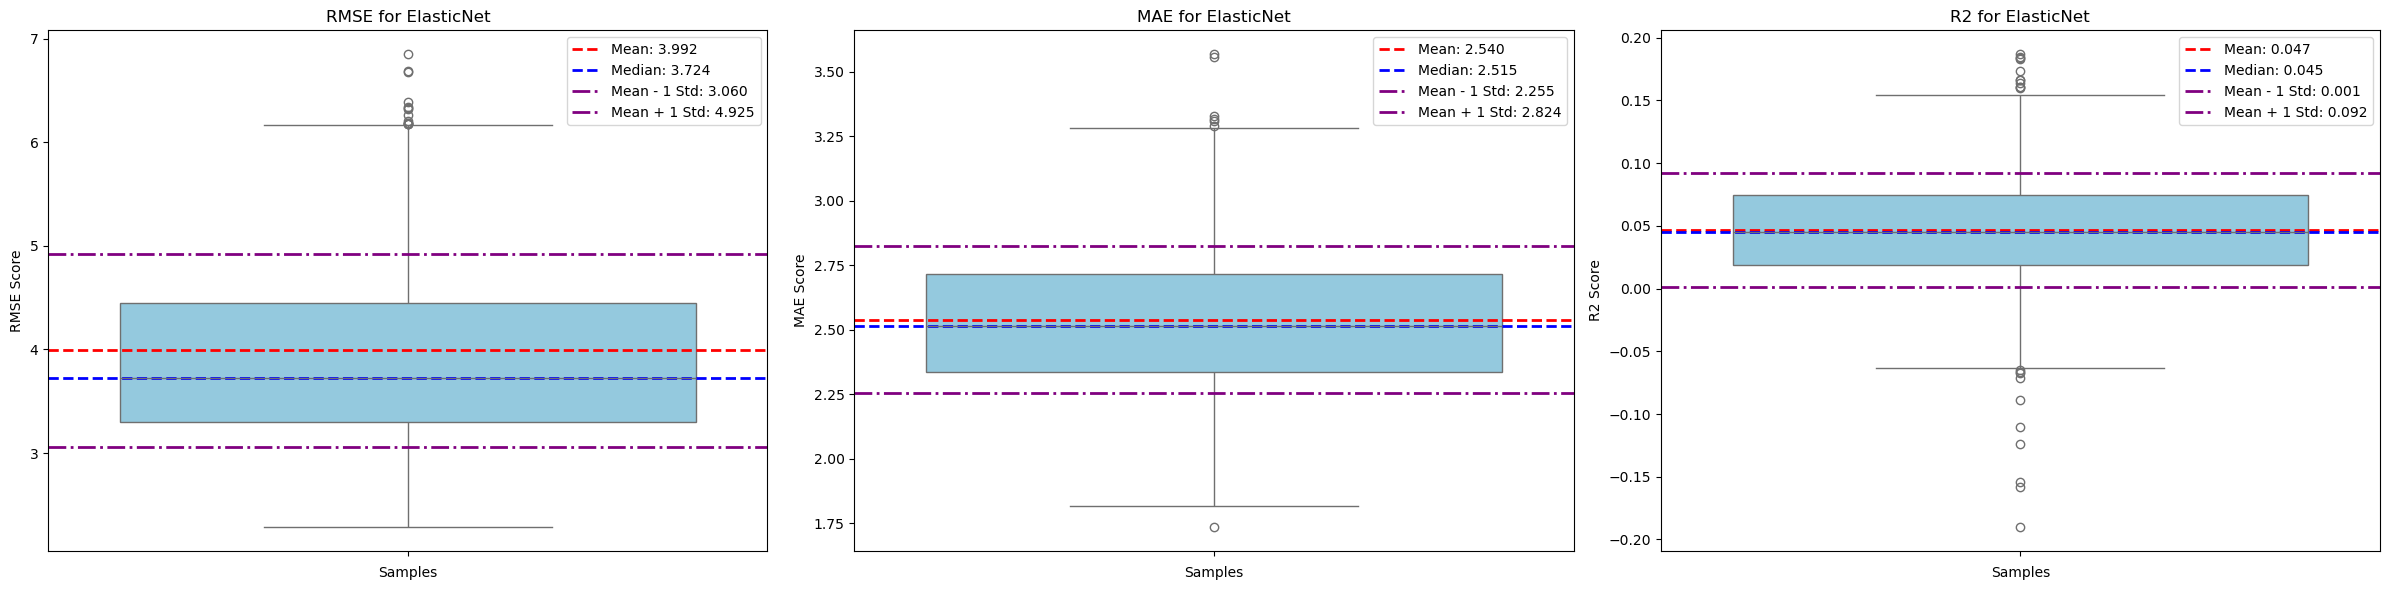

Model: BayesianRidge


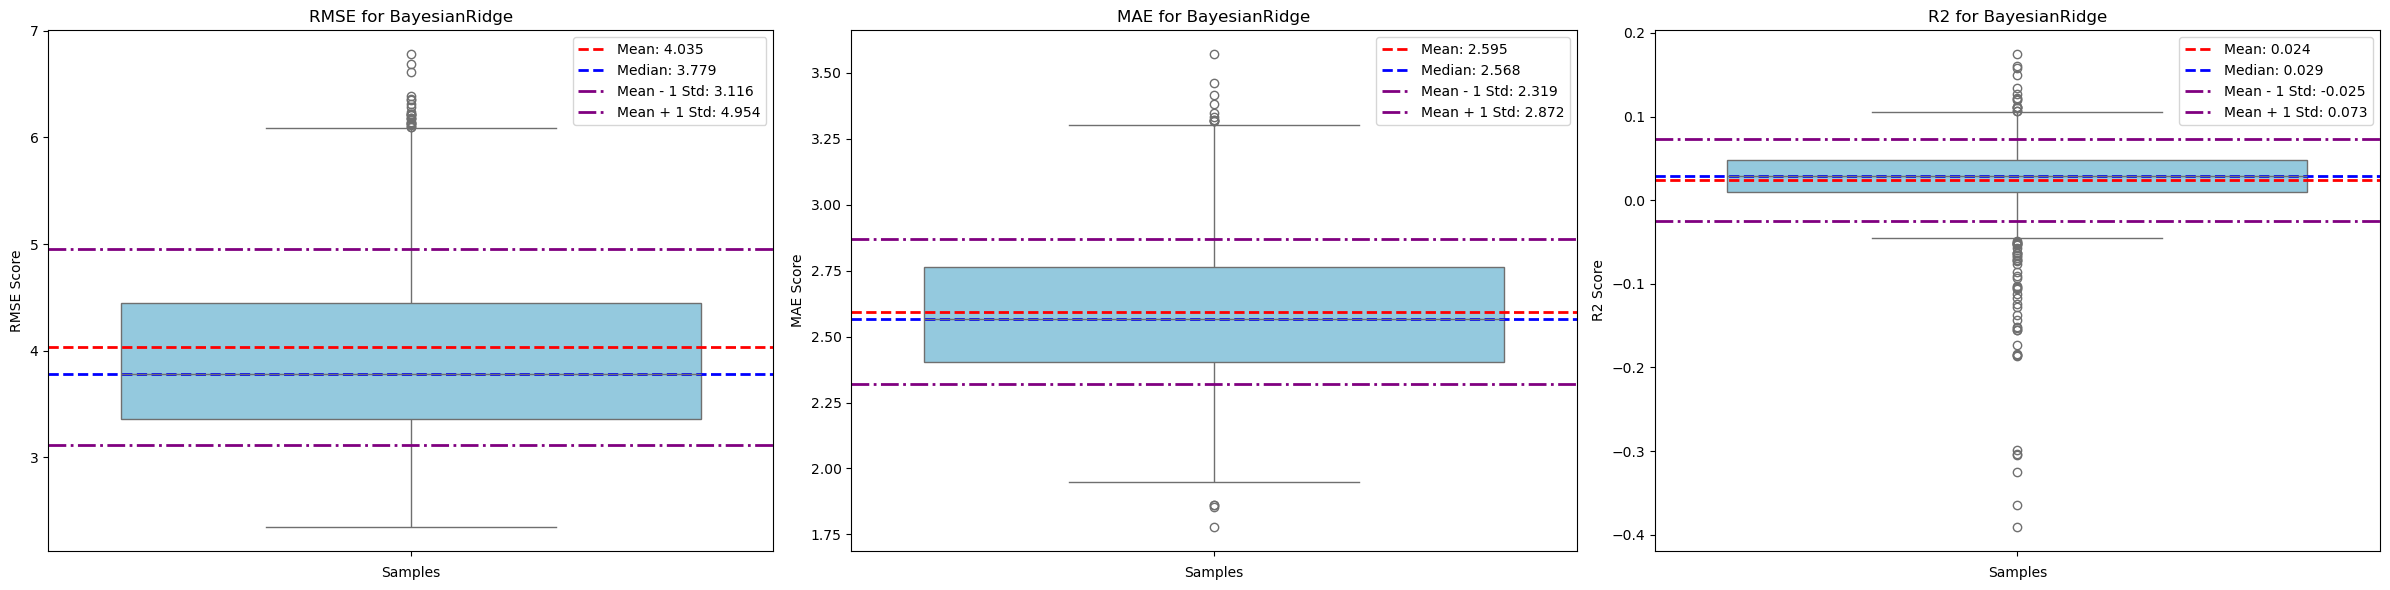

Model: SVR


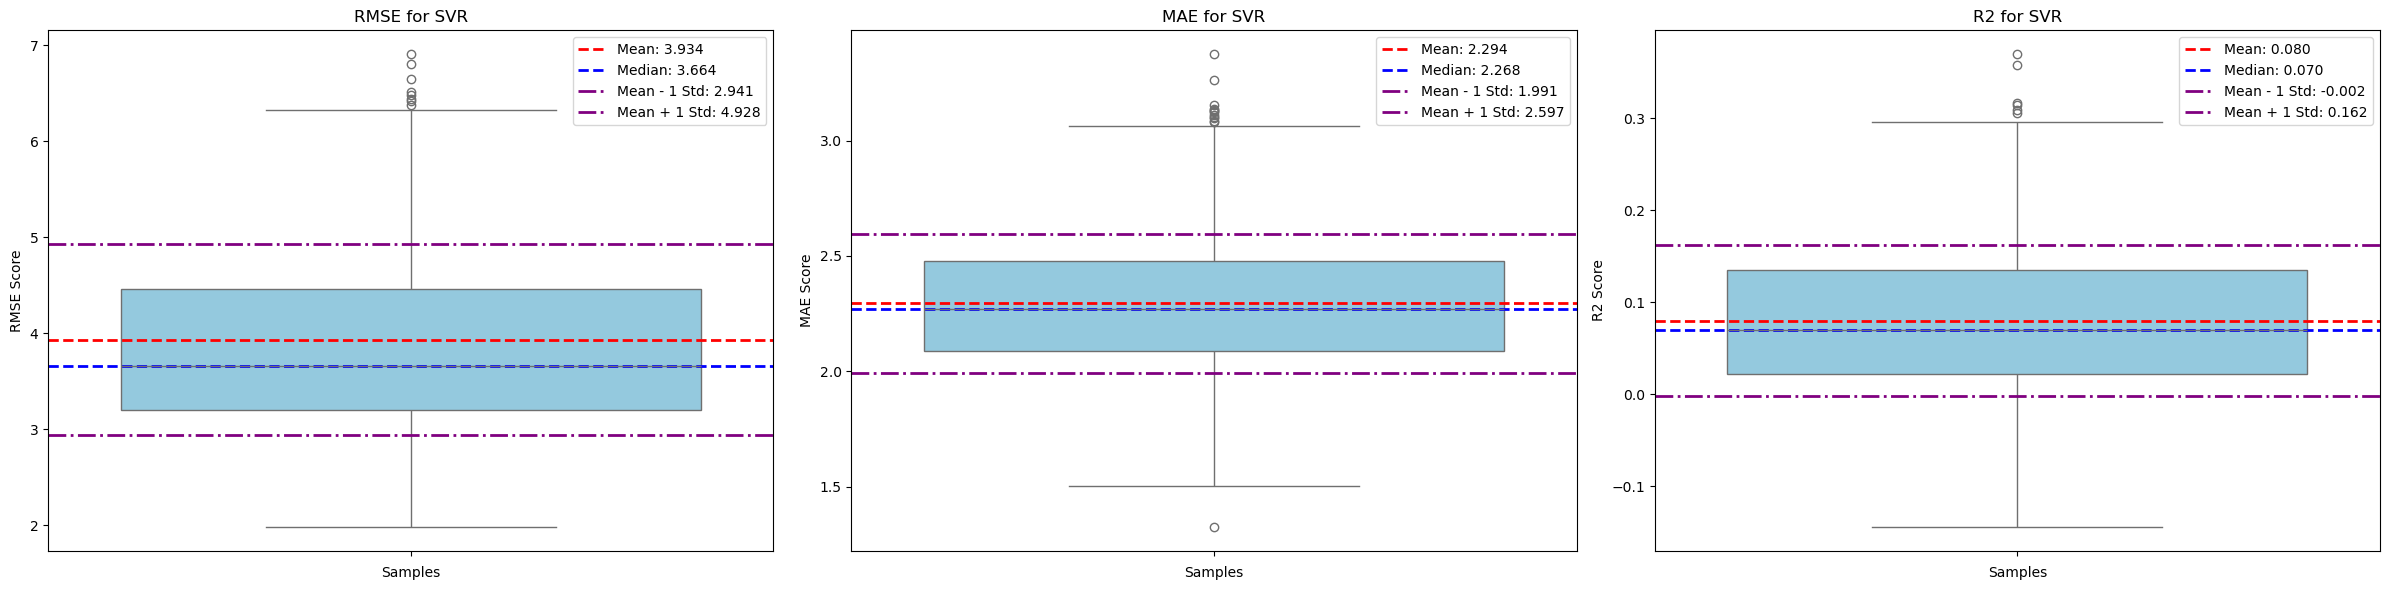

In [5]:
models = [ElasticNet(alpha=1.960912753833466, l1_ratio=0.00029702274581409633), BayesianRidge(alpha_1=1.1398911892360871e-08, alpha_2=2.477163862263266e-06, lambda_1=5.7192945870088304e-08, lambda_2=7.411087584315874e-07), SVR(C=5.001950345154176, gamma='scale', epsilon=0.2036137155533329, kernel='rbf')]
for model in models:
    print(f"Model: {model.__class__.__name__}")
    if model.__class__.__name__ == 'ElasticNet':
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=PCA(n_components=90))

    elif model.__class__.__name__ == 'BayesianRidge':
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=SelectKBest(score_func=mutual_info_regression, k=81))

    else:
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=PCA(n_components=82))
    preds, trained_pipeline = functions.train_model_and_predict(x, y, val_x, pipeline, root_path=root, filename=f"{model.__class__.__name__}_optuna.pkl", save=True)
    scores = functions.bootstrap(x, y, val_x, val_y, pipeline, n_iter=200, bstrap=False, kf=True)
    rmse_scores, mae_scores, r2_scores = scores['rmse_scores'], scores['mae_scores'], scores['r2_scores']
    mean_rmse, std_rmse, median_rmse = functions.calculate_statistics(rmse_scores)
    mean_mae, std_mae, median_mae = functions.calculate_statistics(mae_scores)
    mean_r2, std_r2, median_r2 = functions.calculate_statistics(r2_scores)
    # Create a boxplot
    functions.create_boxplot([rmse_scores, mae_scores, r2_scores], model.__class__.__name__, ["RMSE", "MAE", "R2"], [mean_rmse, mean_mae, mean_r2], [std_rmse, std_mae, std_r2], [median_rmse, median_mae, median_r2])

Model: ElasticNet


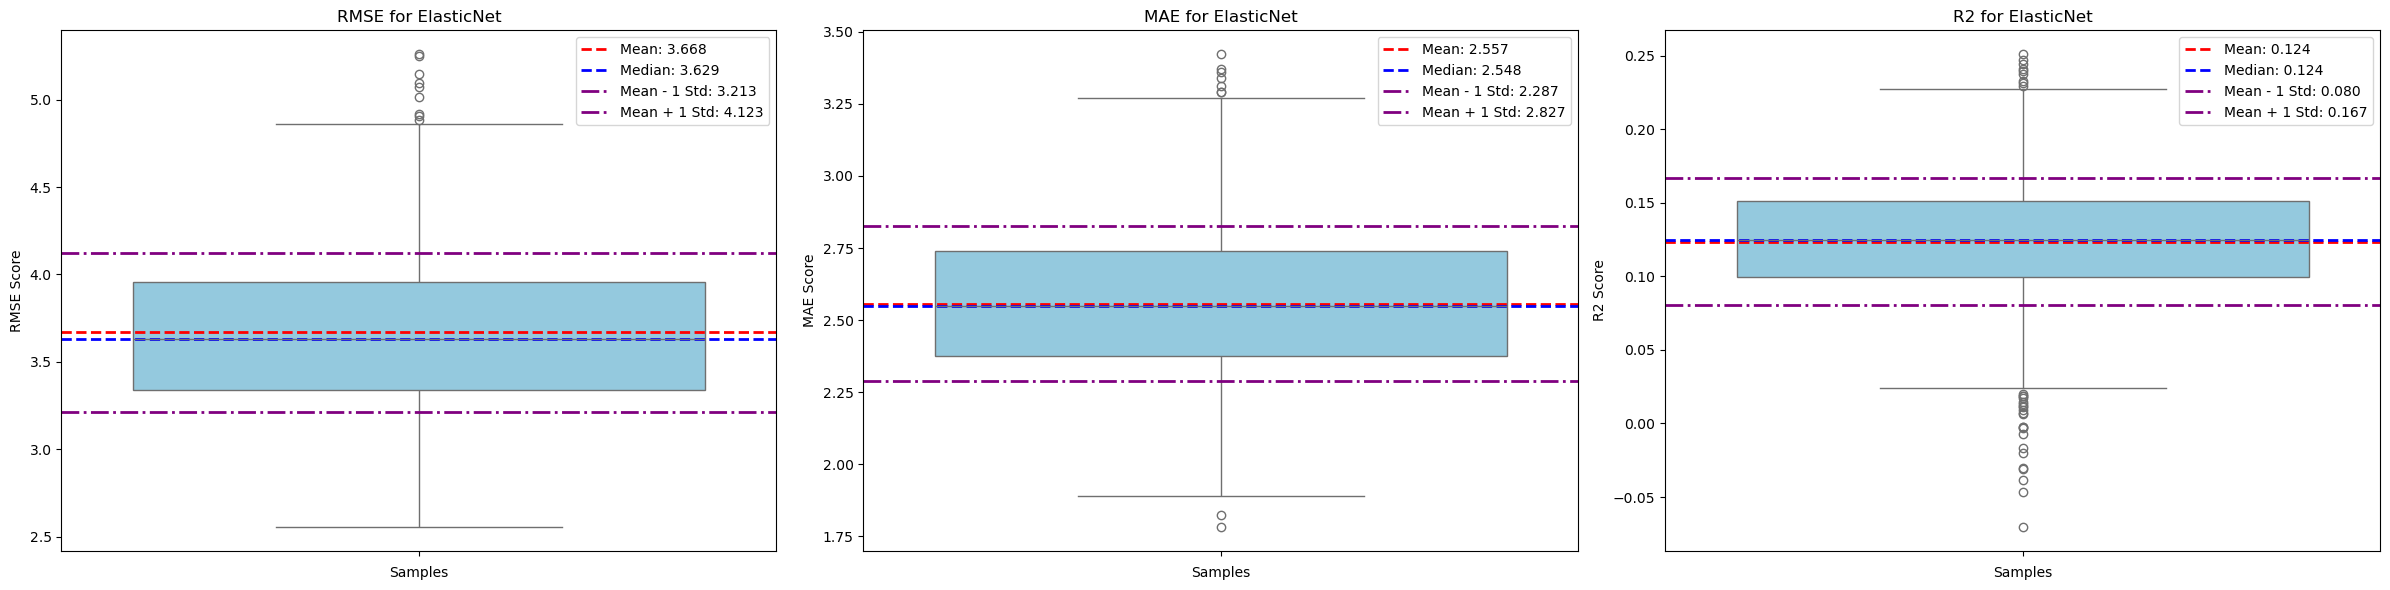

Model: BayesianRidge


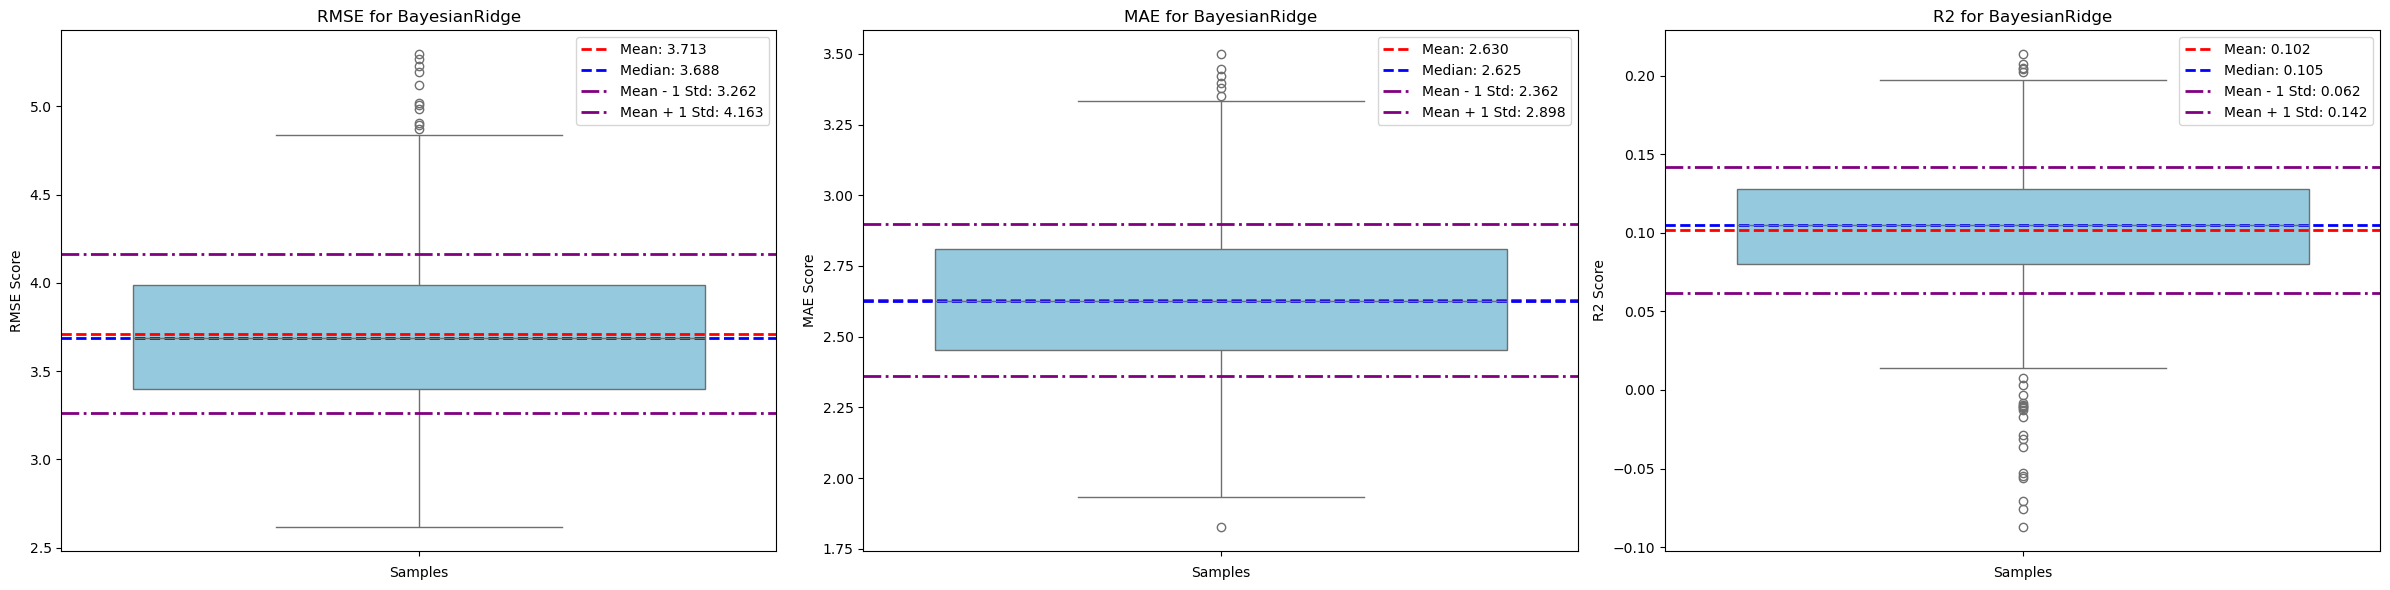

Model: SVR


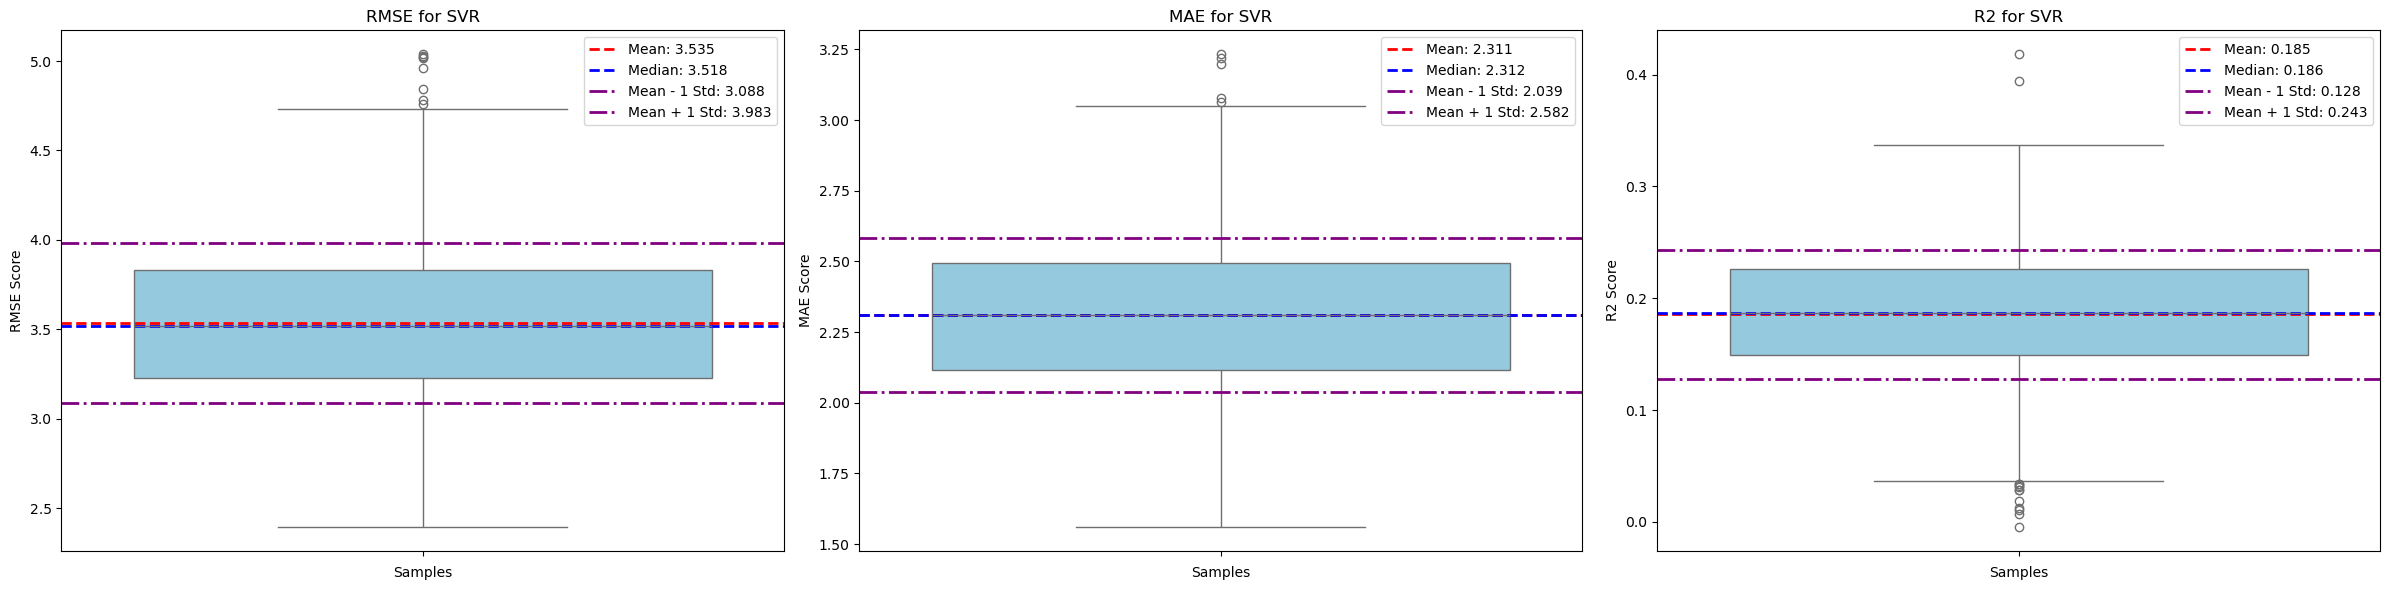

In [6]:
models = [ElasticNet(alpha=1.960912753833466, l1_ratio=0.00029702274581409633), BayesianRidge(alpha_1=1.1398911892360871e-08, alpha_2=2.477163862263266e-06, lambda_1=5.7192945870088304e-08, lambda_2=7.411087584315874e-07), SVR(C=5.001950345154176, gamma='scale', epsilon=0.2036137155533329, kernel='rbf')]
for model in models:
    print(f"Model: {model.__class__.__name__}")
    if model.__class__.__name__ == 'ElasticNet':
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=PCA(n_components=90))

    elif model.__class__.__name__ == 'BayesianRidge':
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=SelectKBest(score_func=mutual_info_regression, k=81))

    else:
        pipeline = functions.create_pipeline(model, scaler=False, feature_selector=PCA(n_components=82))
    scores = functions.bootstrap(x, y, val_x, val_y, pipeline, n_iter=1000, bstrap=True, kf=False)
    rmse_scores, mae_scores, r2_scores = scores['rmse_scores'], scores['mae_scores'], scores['r2_scores']
    mean_rmse, std_rmse, median_rmse = functions.calculate_statistics(rmse_scores)
    mean_mae, std_mae, median_mae = functions.calculate_statistics(mae_scores)
    mean_r2, std_r2, median_r2 = functions.calculate_statistics(r2_scores)
    # Create a boxplot
    functions.create_boxplot([rmse_scores, mae_scores, r2_scores], model.__class__.__name__, ["RMSE", "MAE", "R2"], [mean_rmse, mean_mae, mean_r2], [std_rmse, std_mae, std_r2], [median_rmse, median_mae, median_r2])

<p>After fine-tuning, we performed kfold-cross validation and evaluation and plotted the results as before to be able to compare the performance of our fine-tuned models with the baseline models.</p>

<p>The plots show improved RMSE, MAE and R2 scores for the fine-tuned models compared to the baseline models, as the error related metrics are reduced and the R2 score is increased. Naturally, more research is needed in order to further improve the performance of the models and test additional algorithms.</p>

In [3]:
initial_df = pd.read_csv(root / "data" / "assignment1_dev_set.csv", header=0)
initial_val_df = pd.read_csv(root / "data" / "assignment1_val_set.csv", header=0)
all_df = pd.concat([initial_df, initial_val_df])
winner_path = str(root)+"/models/final_models/"
final_df = all_df.drop(columns=['Unnamed: 0', 'Experiment type', 'Disease MESH ID', 'Sex', 'Project ID', 'Host age'])
x = final_df.drop(columns=['BMI'])
y = final_df['BMI']
final_pipeline = functions.create_pipeline(SVR(C=5.001950345154176, gamma='scale', epsilon=0.2036137155533329, kernel='rbf'), scaler=True, feature_selector=PCA(n_components=82))
preds, trained_pipeline = functions.train_model_and_predict(x, y, x, final_pipeline, root_path=winner_path, filename="winner.pkl", save=True, default_path=False)
print(preds)

[25.24252528 23.70386577 25.71858856 23.72068174 22.76645993 25.39589589
 25.89169545 25.7619902  24.54648542 25.35302952 21.17152085 23.84129468
 23.3327828  25.26960306 21.09456302 22.51579776 24.23441805 25.16917162
 20.40181682 25.21448105 23.70725741 27.40610257 20.20213087 24.49078555
 25.59749633 23.17594443 26.49145213 25.90187233 23.872343   24.55577825
 25.3065069  25.53087178 25.55371226 25.3065069  22.91509981 22.78201157
 20.5327049  25.3065069  24.83790945 25.89111731 25.05942519 23.97446508
 23.0316964  21.35992666 25.99973547 27.23081301 25.21400334 25.46809895
 25.3065069  19.87748078 22.73896104 23.39295658 25.6269228  23.93841919
 25.07461011 24.8532874  22.78280578 25.3065069  23.12546351 25.59893935
 21.16770881 24.91539772 27.76940515 23.43693834 24.54280566 25.74054228
 26.0774828  25.59052182 22.67385703 23.10893696 25.41719213 25.3065069
 25.3065069  26.70421398 22.77425264 29.44872542 25.42642023 24.00850726
 26.59482098 19.40489867 25.59311816 22.17462381 25.

<hr>

## Winner model loading section
<p>Here the function from from functions.py is called to load the winner model and make predictions on the test data.</p>

**You can load the winner model by pasting the absolute path to the function below.**

In [3]:
preds = functions.bmi_pred(df_path='/Volumes/Mac/Users/rafailadam/Downloads/mlincompbio/Assignment-1/data/assignment1_val_set.csv')
print(preds)

[25.49728678 25.3065069  22.55032142 25.40847666 25.3065069  25.59400061
 21.10134302 26.29681347 24.99271127 25.54079755 21.75975083 22.28420013
 25.7680026  20.59339108 25.47555579 24.34190272 24.36599986 24.81929137
 24.51093602 25.25816923 24.27902163 26.67495157 29.36081883 25.63281478
 25.60322965 25.3065069  25.17959586 25.27434174 20.20365506 26.00009691
 21.59744515 26.52623372 19.77669606 25.89255429 26.00288362 26.50808102
 26.0210332  26.53471821 23.67863408 25.33000537 26.13784565 31.81291905
 25.75618449 22.75817703 23.10600811 24.10821432 20.58648927 23.70810007
 25.3065069  20.19292358 30.06287147 21.61580841 25.29043365 27.16635171
 25.30298491 22.46016027 25.69263817 25.89571046 26.00266917 23.93113707
 26.41025573 25.57198663 20.73505346 21.42239957 22.99165186 21.24458903
 23.55365124 25.96009658 25.3065069  20.23237196 27.4601881  26.52898974
 25.3065069  25.21151846 21.50755961 25.50455525 25.3065069  22.26400943
 25.67619567 21.00382192 24.8507826  28.43563245 24